##Import Packages and Set Directory

The following packages will be used in this notebook. The dataset will also be read from local user's Google Drive. 

In [1]:
!pip install keras_tuner
!pip install git+https://github.com/paulgavrikov/visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-zuvwylb7
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-zuvwylb7
  Resolved https://github.com/paulgavrikov/visualkeras to commit d7111d3471173c0b16853a6ce5e4cc645498380a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 25.0 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13450 sha256=512c0ba39a5d814323fa3080215427b91d4630f4611c2de5080ab8017e675b05
  Stored in directory: /tmp/pip-ephem-wheel-cache-i1shoif7/wheels/e6/fe/80/74c54ccb79205ab57079259bc349e1629373e811e1c82ed535
Successfully built visualkeras


In [2]:
#reading directory and datasets
import pathlib 
from glob import glob 
import PIL 

#dataframes and arrays 
import pandas as pd
import numpy as np 

#plotting 
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
from keras.utils.vis_utils import plot_model

#building & fitting the model 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 

#evaluation & fine tuning
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2
import keras_tuner as kt 
import math 


In [3]:
## allow colab to read from google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
##working directory containing the dataset to interact with 
data_dir = pathlib.Path('drive/MyDrive/train_data')    #please change to your local filepath directory when running 

## Import Dataset & Data Manipulation

We will first briefly look at the chest X-ray images 

In [ ]:
## save image path for each class in a list 
normal_xray = list(data_dir.glob('NORMAL/*.jpeg'))
pneum_xray = list(data_dir.glob('PNEUMONIA/*.jpeg'))

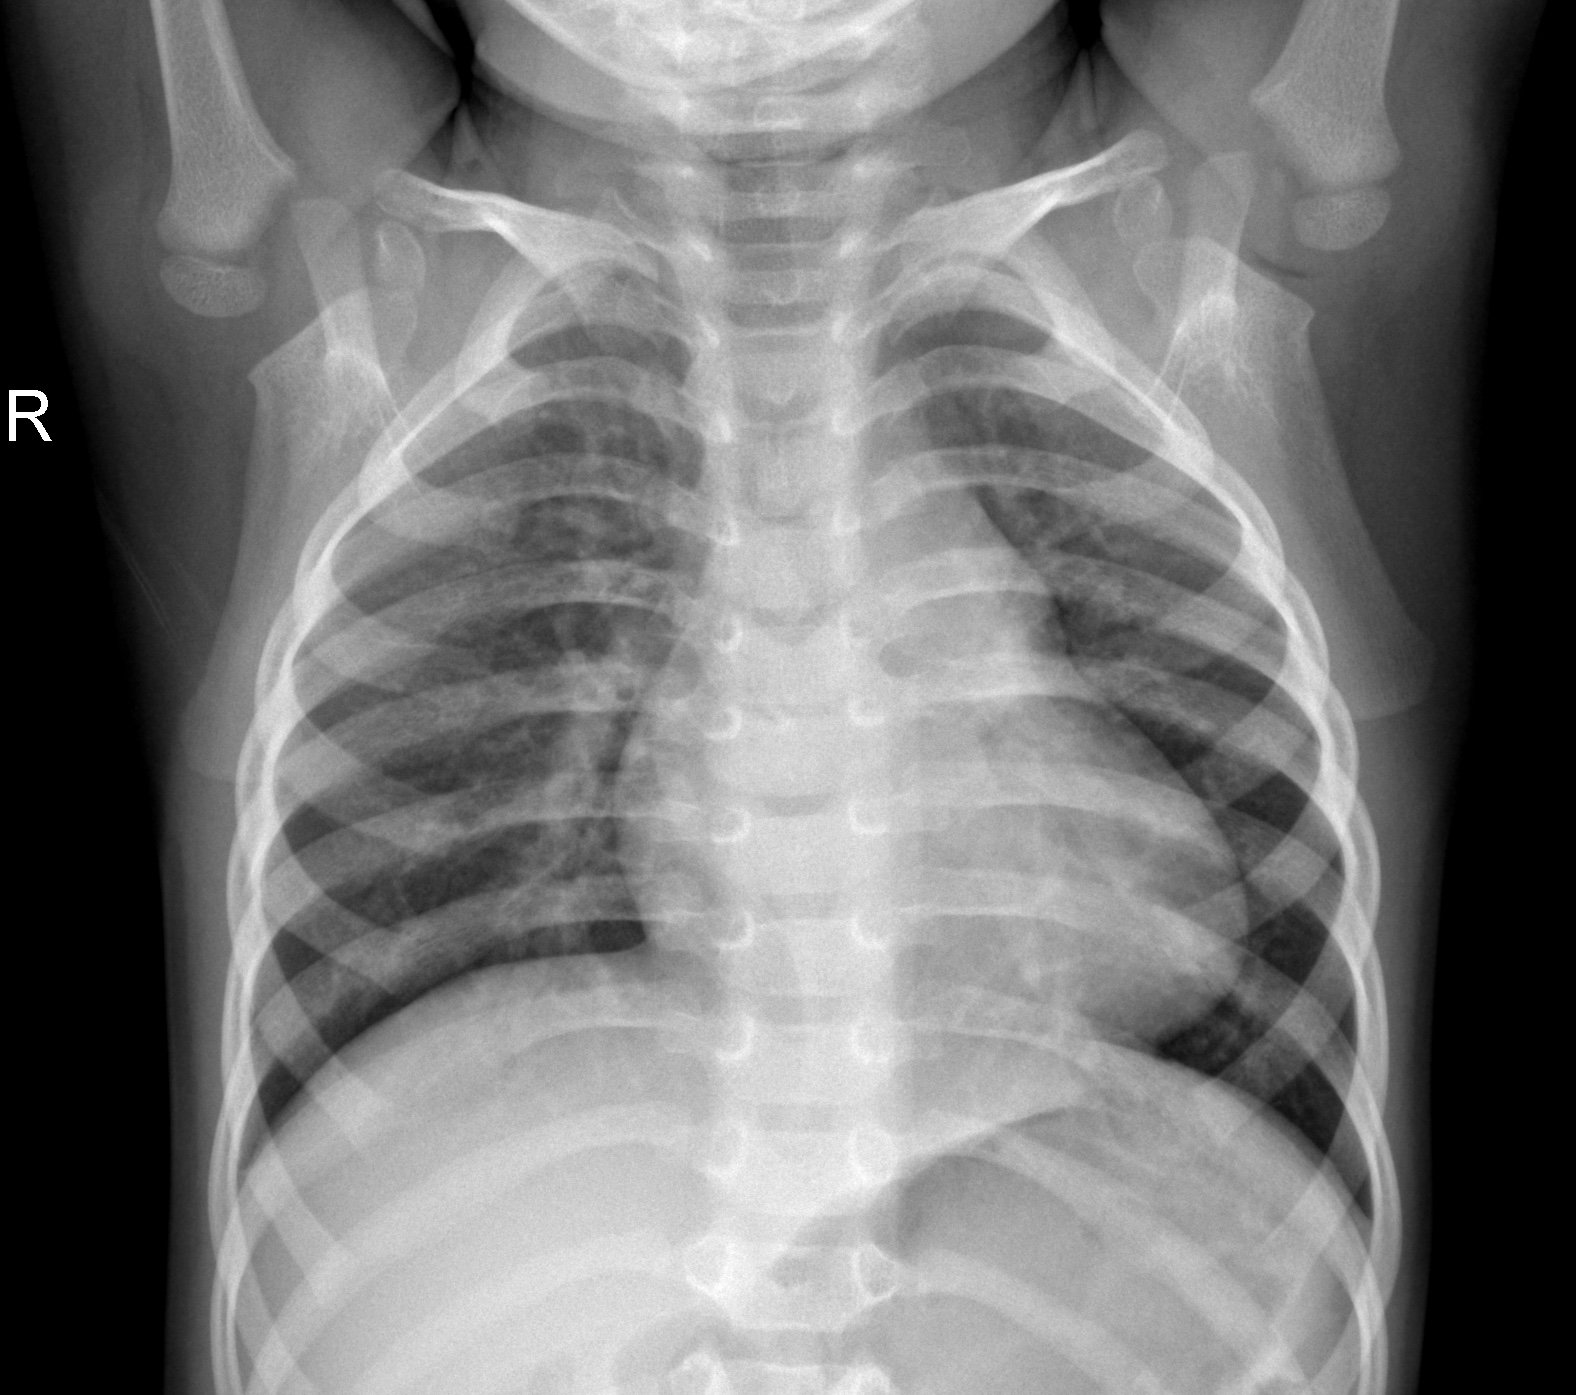

In [ ]:
## view an example of a normal X-ray
normal_im = PIL.Image.open(str(normal_xray[0]))
normal_im

In [ ]:
#print the size of the image
normal_im.size

(1576, 1395)

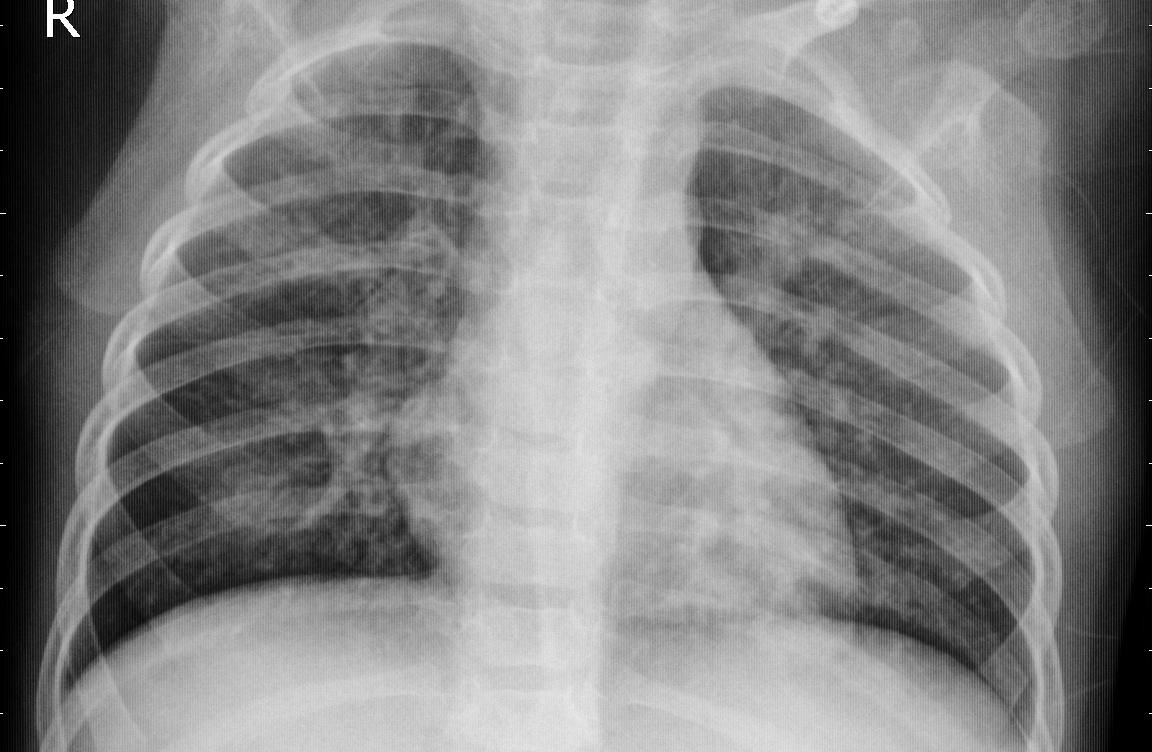

In [ ]:
## view example of pneumonia xray
pneum_im = PIL.Image.open(str(pneum_xray[0]))
pneum_im

In [ ]:
pneum_im.size

(1152, 752)

In [ ]:
pneum_im2 = PIL.Image.open(str(pneum_xray[1]))
pneum_im2.size

(952, 584)

We observe that all Xray pictures are of different sizes. 


The image sizes have to be standardized for building our model. To determine which dimension and aspect ratio to use, we can examine the aggregate values of our image sizes

In [ ]:
## WARNING: May take some time to run 
data = []
for pic in (normal_xray + pneum_xray):
    with PIL.Image.open(pic) as img:
        width, height = img.size
        asp_ratio = width/height
        data.append([pic, width, height, asp_ratio])

img_df = pd.DataFrame(data, columns = ['path','width', 'height', 'aspect ratio'])
img_df

path  width  height  \
0     drive/MyDrive/train_data/NORMAL/NORMAL-3271929...   1576    1395   
1     drive/MyDrive/train_data/NORMAL/NORMAL-3400382...   1546    1425   
2     drive/MyDrive/train_data/NORMAL/NORMAL-3269314...   1666    1171   
3     drive/MyDrive/train_data/NORMAL/NORMAL-3333785...   1218    1032   
4     drive/MyDrive/train_data/NORMAL/NORMAL-3526928...   1754    1221   
...                                                 ...    ...     ...   
5247  drive/MyDrive/train_data/PNEUMONIA/BACTERIA-37...   1546    1231   
5248  drive/MyDrive/train_data/PNEUMONIA/BACTERIA-39...   1280     751   
5249  drive/MyDrive/train_data/PNEUMONIA/BACTERIA-37...   1296    1040   
5250  drive/MyDrive/train_data/PNEUMONIA/BACTERIA-41...    888     560   
5251  drive/MyDrive/train_data/PNEUMONIA/BACTERIA-41...   1184     704   

      aspect ratio  
0         1.129749  
1         1.084912  
2         1.422716  
3         1.180233  
4         1.436527  
...            ...  
5247      1.255890  
5248      1.704394  
5249      1.246154  
5250      1.585714  
5251      1.681818  

[5252 rows x 4 columns]

In [ ]:
## basic statistics of the image sizes and aspect ratio
img_df.describe()

width       height  aspect ratio
count  5252.000000  5252.000000   5252.000000
mean   1320.181455   967.732102      1.440065
std     354.750421   378.171623      0.256954
min     384.000000   127.000000      0.835391
25%    1056.000000   688.000000      1.257406
50%    1284.000000   888.000000      1.411215
75%    1552.000000  1187.000000      1.583333
max    2916.000000  2663.000000      3.378788

Smaller image sizes work better for model training as they significantly reduce the training time. As such, we can aim to resize all images to the smallest image size in the dataset.

In [ ]:
## verify that the smallest width and smallest height are from the same image
img_df[img_df['width'] == 384]

path  width  height  \
1364  drive/MyDrive/train_data/PNEUMONIA/VIRUS-35559...    384     127   

      aspect ratio  
1364      3.023622

The image width can be set to 350

Next, we also check the aspect ratio of most images to determine a proper aspect ratio for the resizing. 

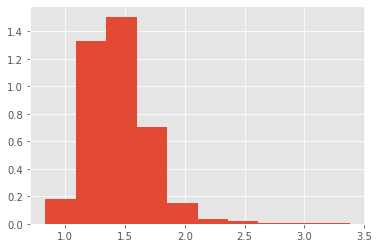

In [ ]:
plt.style.use('ggplot')
img_df['aspect ratio'].hist(density = True)

Based on the mean, median, and distribution of aspect ratio, setting the aspect to 1.45 will be best to ensure most of the images are properly represented

In [ ]:
350/1.45      #the value for image height

241.3793103448276

## Create Dataset

Based on our observation, we can set our image dimensions to 350 by 240. The batch size is also set to the standard size of 32 images/per batch.

Note: We will resize the images when reading them in instead of resizing them in our model to reduce our training time. 

In [5]:
batch_size = 32 
img_height = 240 
img_width = 350

Next, we read in our datasets and split them into a training and testing set. We use a train-test split of 70-30. 

In [6]:
## Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,               
  validation_split=0.3,
  subset="training",
  seed = 27,              #set seed for reproducibiility 
  shuffle=True,           #shuffle the dataset to ensure we have a varied/unstructured data
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5252 files belonging to 2 classes.
Using 3677 files for training.


In [7]:
## Testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split = 0.3,
    subset = "validation", 
    seed = 27,        
    shuffle=True,          
    image_size = (img_height, img_width), 
    batch_size = batch_size 
)

Found 5252 files belonging to 2 classes.
Using 1575 files for validation.


In [8]:
## save class names in a list
data_class_names = train_ds.class_names
data_class_names

['NORMAL', 'PNEUMONIA']

Let us plot and view both of our training and testing dataset

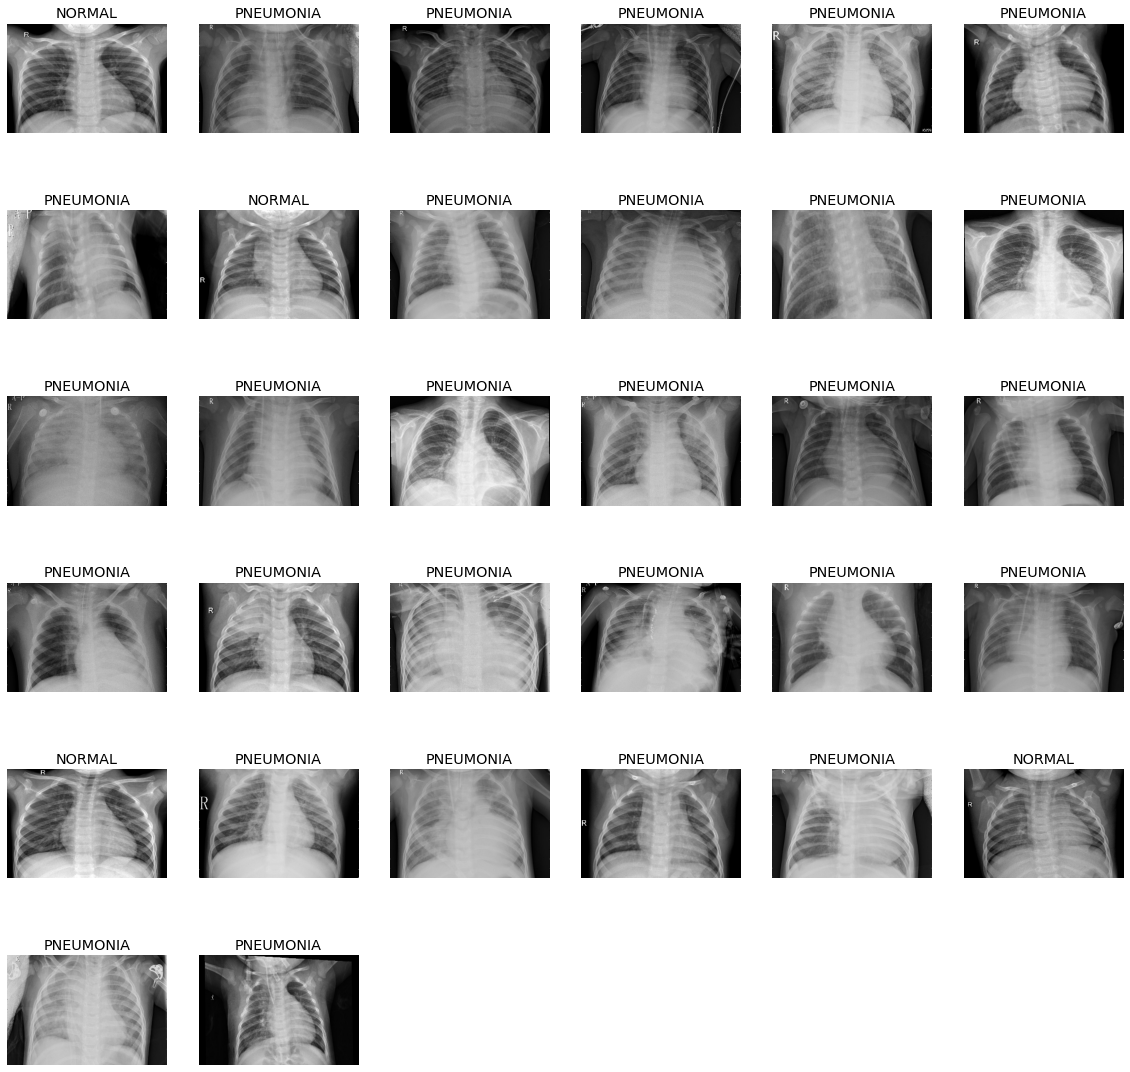

In [ ]:
plt.figure(figsize = (20, 20))
for images, labels in train_ds.take(1): 
  for i in range(32): 
    ax = plt.subplot(6, 6, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data_class_names[labels[i]])
    plt.axis("off")

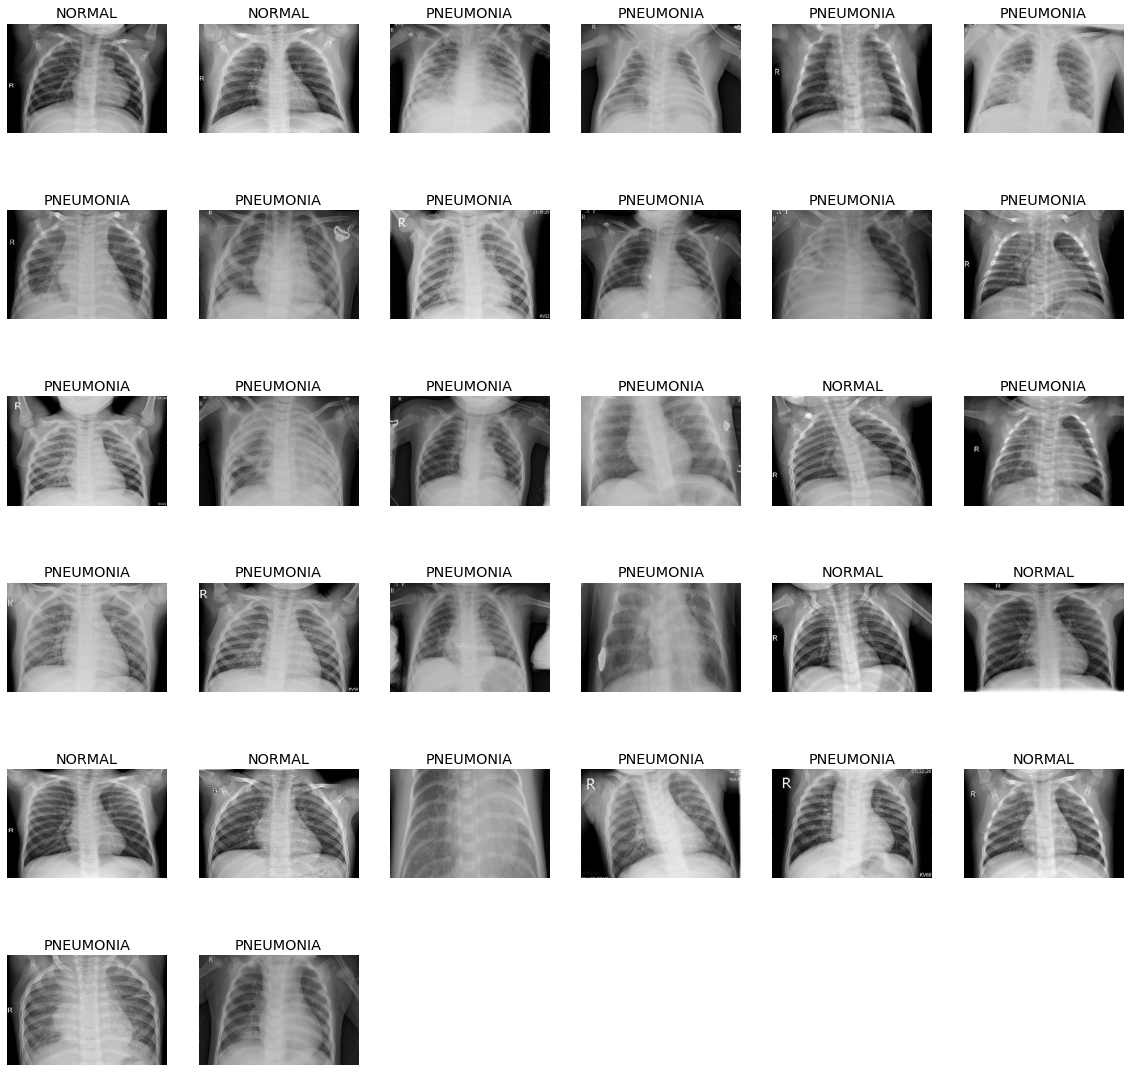

In [ ]:
plt.figure(figsize = (20, 20))
for images, labels in test_ds.take(1): 
  for i in range(32): 
    ax = plt.subplot(6, 6, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data_class_names[labels[i]])
    plt.axis("off")

We can also verify the shapes of our training and testing data. 

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
print(image_batch.shape)   
print(labels_batch.shape)

(32, 240, 350, 3)
(32,)


In [ ]:
image_batch, labels_batch = next(iter(test_ds))
print(image_batch.shape)   
print(labels_batch.shape)

(32, 240, 350, 3)
(32,)


The shapes of the tensor are as desired. (32, 240, 350, 3) represent 32 images per batch, each of size 240 by 350 with 3 RGB layers

### Data Configuration

Finally, we configure our dataset for performance. We use buffered prefetching, to allow us to retrieve the data without having I/O blocking us.  

We first cache the data to save it in memory after they are loaded in the first epoch. This is especially important to optimize our runtime given that we have a fairly large amount of training images (over 3500). 

Then we also prefetech to allow the data preprocessing and model execution to simulataneously run while training, and hence optimizing our training time. 

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
# Cache data 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Prefetch data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardization of Data

As we see below, the RGB channel values are in the range of 0 to 255. 

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 254.89


This results in the following distribution of the channel values of the dataset. This is not ideal since 
1) unnormalizaed data can pose instability, improper representation when creating our model and, 
2) smaller values are preferred for model training. 
As such we must rescale the data as follows. 

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9986891


The pixel values are now in the range of 0 and 1 . The normalization layer will be used in our model architecture 

## Model Building

We go through a series of model building and evaluation, starting from a base model and then going through a series of fine tuning and data adjustment processes to optimize our model. 

### Base Model

We start with a base model containig 3 pairs of convolution-max pooling layers, and then fully connected layers to output. 


#### Model Architecture

In [10]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

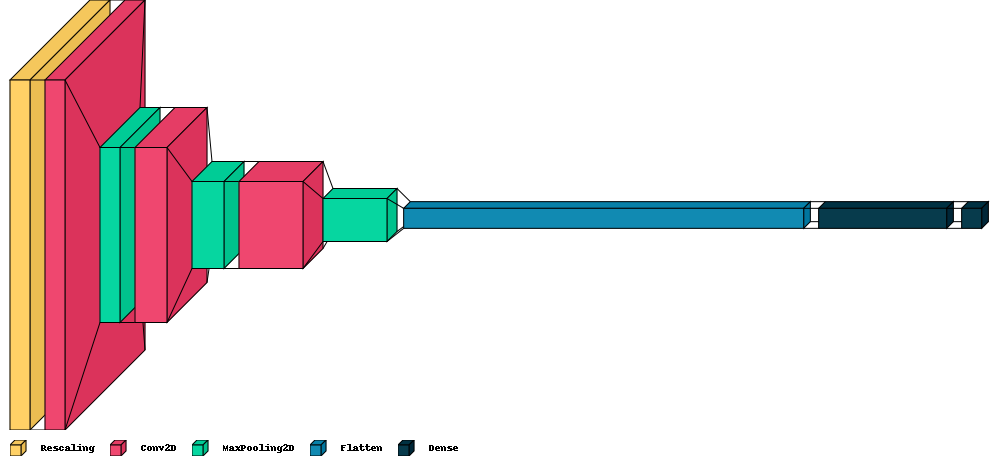

In [ ]:
visualkeras.layered_view(model, legend=True, spacing=15, scale_xy=1, scale_z=1, to_file='drive/MyDrive/DSA4266/model_viz.png')

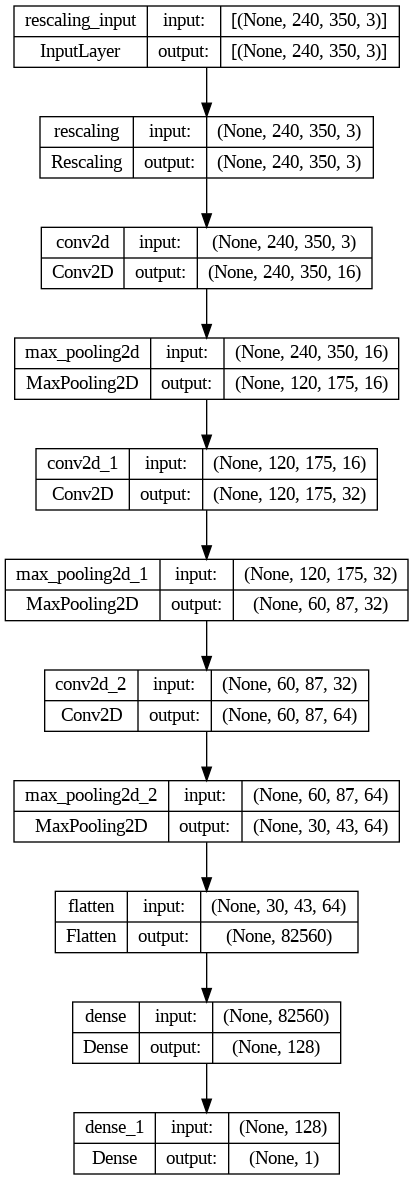

In [ ]:
plot_model(model,  show_shapes=True, to_file='drive/MyDrive/DSA4266/model_plot.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 350, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 350, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 175, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 175, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 87, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 87, 64)        1

For our optimizer, we make use of Adam optimizer, which uses and adaptive learning rate to allow  faster convergence rate and tackle any heavy-tailed noise. 

We also start with a small learning rate to avoid overshooting at a very early stage. 

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

We also use earlystopping to mitigate overfitting and terminate the training when the validation loss stops increasing through the epoch. 

The patience value is set at around 10% of the number of epochs used to take into account any scenario where the model may still eventually improve despite a temporary dip in the accuracy (or rise in the error rate). 

#### Model Training

In [12]:
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10,     
                                        restore_best_weights = True)

In [ ]:
model_fit = model.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 100, 
    callbacks = [earlystopping]
)

Epoch 1/100
115/115 [==============================] - 661s 2s/step - loss: 0.5341 - accuracy: 0.7493 - val_loss: 0.4543 - val_accuracy: 0.7479
Epoch 2/100
115/115 [==============================] - 7s 59ms/step - loss: 0.3837 - accuracy: 0.8240 - val_loss: 0.3168 - val_accuracy: 0.9086
Epoch 3/100
115/115 [==============================] - 6s 54ms/step - loss: 0.2723 - accuracy: 0.9086 - val_loss: 0.2336 - val_accuracy: 0.9117
Epoch 4/100
115/115 [==============================] - 6s 54ms/step - loss: 0.2059 - accuracy: 0.9293 - val_loss: 0.1861 - val_accuracy: 0.9371
Epoch 5/100
115/115 [==============================] - 7s 57ms/step - loss: 0.1692 - accuracy: 0.9426 - val_loss: 0.1594 - val_accuracy: 0.9416
Epoch 6/100
115/115 [==============================] - 6s 54ms/step - loss: 0.1422 - accuracy: 0.9527 - val_loss: 0.1386 - val_accuracy: 0.9556
Epoch 7/100
115/115 [==============================] - 7s 58ms/step - loss: 0.1257 - accuracy: 0.9565 - val_loss: 0.1216 - val_accuracy:

In [ ]:
model.save('drive/MyDrive/DSA4266/base_model')        #the model is saved to allow us to load it back again if we need it in another runtime

#### Model Evaluation

In [ ]:
print(model.evaluate(test_ds))

50/50 [==============================] - 1s 22ms/step - loss: 0.0671 - accuracy: 0.9816
[0.06705115735530853, 0.981587290763855]


We first look at how the accuracy and loss values on the training and testing datasets respectively change throughout the training period. This mainly serves to check the effectiveness of our training and observe if we are running into overfitting/underfitting. 

We define a function to plot the the accuracy and loss values throughout the training period as shown below to reduce reduancy of our code. 

In [14]:
plt.style.use('ggplot')
def plot_accuracy_loss(fit_history): 
  #extract the training and validation accuracy values
  train_acc = fit_history.history['accuracy']
  val_acc = fit_history.history['val_accuracy']

  #extract the training and validation loss values
  train_loss = fit_history.history['loss']
  val_loss = fit_history.history['val_loss']

  num_epochs = len(fit_history.history['val_accuracy'])
  x_range = range(num_epochs)
  
  acc_lower_range = math.floor(min(train_acc + val_acc)/0.05) * 0.05
  acc_upper_range = math.ceil((max(train_acc + val_acc)+0.05)/0.05) * 0.05
  loss_lower_range = math.floor(min(train_loss + val_loss)/0.05) * 0.05
  loss_upper_range = math.ceil((max(train_loss + val_loss)+0.05)/0.05) * 0.05

  #Plot the training and accuracy values over the number of epochs 
  plt.figure(figsize=(10, 8))
  plt.subplot(1, 2, 1)
  plt.plot(x_range, train_acc, label='Training Accuracy')
  plt.plot(x_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xticks(np.arange(min(x_range), max(x_range)+1, 5))
  plt.yticks(np.arange(acc_lower_range, acc_upper_range, 0.05))

  #Plot the training and accuracy loss over the number of epochs 
  plt.subplot(1, 2, 2)
  plt.plot(x_range, train_loss, label='Training Loss')
  plt.plot(x_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xticks(np.arange(min(x_range), max(x_range)+1, 5))
  plt.yticks(np.arange(loss_lower_range, loss_upper_range, 0.05))
  
  plt.show()



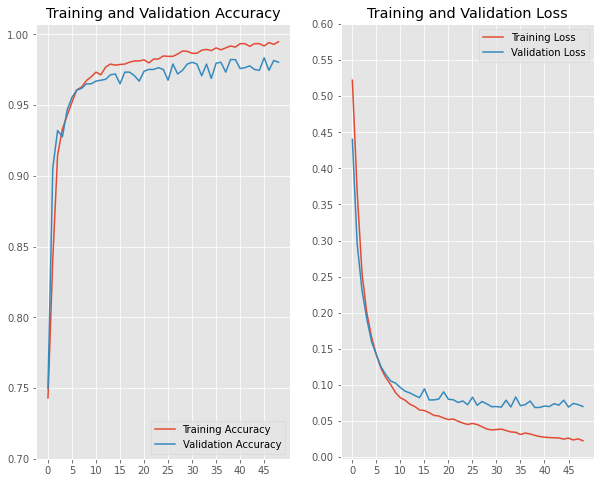

In [15]:
plot_accuracy_loss(model_fit)

Observations: 
1) The training loss has a decreasing trend while the validation loss remains rather stable (with occassional spikes) after 30 epochs onwards. 
2) The training accuracy has a smoother rate of increase while the validation accuracy fluctuates at about the same range approximately 30 epochs onwards. 

In [ ]:
def model_prediction(model_name): 
  predictions = model_name.predict(test_ds)
  plt.hist(np.ndarray.flatten(predictions))
  return predictions 

50/50 [==============================] - 1s 18ms/step


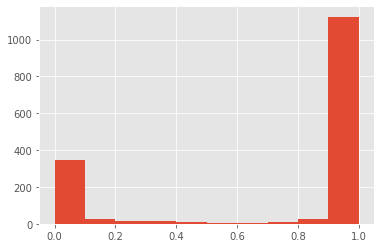

In [ ]:
model_predict = model_prediction(model)

In [ ]:
def evaluation_metrics(predictions, threshold): 
  pred_class = (predictions > threshold).astype(np.float32)
  true_categories = tf.concat([y for x, y in test_ds], axis=0)

  cm = confusion_matrix(pred_class, true_categories)
  plt.figure(figsize=(8,8))
  ax= plt.subplot()
  sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [data_class_names[i] for i in range(len(data_class_names))], 
                      yticklabels = [data_class_names[i] for i in range(len(data_class_names))], fmt="d")
  ax.set_xlabel('Actual')
  ax.set_ylabel('Predicted')
  fig = sns_hmp.get_figure()

  FN = cm[0,1]
  FP = cm[1,0]
  TP = cm[1,1]
  TN = cm[0,0]

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  print("True Positive Rate/Recall: ", TPR)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  print("True Negative Rate", TNR)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  print("False Positive Rate: ", FPR)
  # False negative rate
  FNR = FN/(TP+FN)
  print("False Negative Rate: ", FNR)

  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  print("Accuracy: ", ACC)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  print("Precision: ", PPV)
  # F1 Score 
  F1 = 2 * (PPV * TPR) / (PPV + TPR)
  print ("F1 Score:", F1)
  # False discovery rate
  FDR = FP/(TP+FP)
  print("False Discovery Rate: ", FNR)
  # Negative predictive value
  NPV = TN/(TN+FN)
  print("Negative Predictive: ", NPV)


True Positive Rate/Recall:  0.9863481228668942
True Negative Rate 0.967741935483871
False Positive Rate:  0.03225806451612903
False Negative Rate:  0.013651877133105802
Accuracy:  0.9815873015873016
Precision:  0.9888793840889649
F1 Score: 0.9876121315677061
False Discovery Rate:  0.013651877133105802
Negative Predictive:  0.9605911330049262


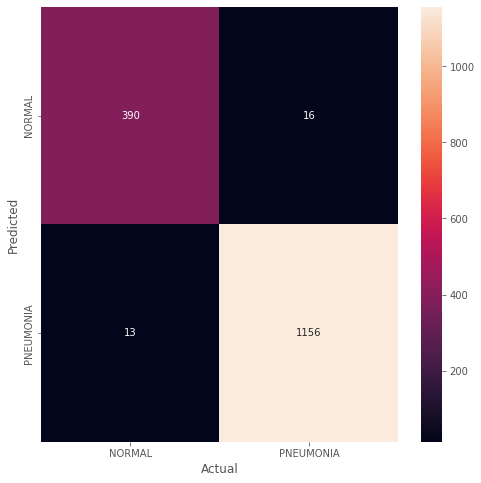

In [ ]:
evaluation_metrics(model_predict, 0.5)

### Reducing Overfitting

#### Adjusting Early Stopping

Based on the observations made in the previous section, one of the most straightforward approach to mitigate overfitting would be to have a stricter criteria for early stopping. 

More precisely, we can stop set the number of epochs to 30 epochs and also reduce our patience for earlystopping to 3.

In [ ]:
 #the backend session is regularly cleard throughout the notebook to clear the backend memory of the global state from old models and preventing it from unnecessarily increasing the runtime
tf.keras.backend.clear_session()       

In [ ]:
model_early = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)

In [ ]:
model_early.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
model_early_fit = model_early.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 30, 
    callbacks = [earlystopping]
)

Epoch 1/30
115/115 [==============================] - 9s 62ms/step - loss: 0.5299 - accuracy: 0.7425 - val_loss: 0.4551 - val_accuracy: 0.8102
Epoch 2/30
115/115 [==============================] - 6s 53ms/step - loss: 0.3772 - accuracy: 0.8355 - val_loss: 0.3169 - val_accuracy: 0.8590
Epoch 3/30
115/115 [==============================] - 6s 54ms/step - loss: 0.2736 - accuracy: 0.9021 - val_loss: 0.2329 - val_accuracy: 0.9213
Epoch 4/30
115/115 [==============================] - 6s 53ms/step - loss: 0.2098 - accuracy: 0.9274 - val_loss: 0.1919 - val_accuracy: 0.9416
Epoch 5/30
115/115 [==============================] - 6s 54ms/step - loss: 0.1654 - accuracy: 0.9432 - val_loss: 0.1611 - val_accuracy: 0.9505
Epoch 6/30
115/115 [==============================] - 7s 57ms/step - loss: 0.1401 - accuracy: 0.9549 - val_loss: 0.1363 - val_accuracy: 0.9543
Epoch 7/30
115/115 [==============================] - 6s 53ms/step - loss: 0.1193 - accuracy: 0.9595 - val_loss: 0.1163 - val_accuracy: 0.9644

In [ ]:
model_early.save('drive/MyDrive/DSA4266/earlystop_model')

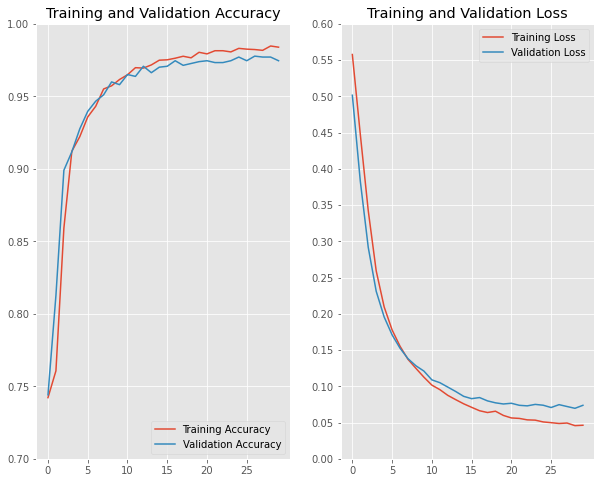

In [ ]:
plot_accuracy_loss(model_early_fit)

As exptected, the plots now reveal that the model is not running to overfitting and is stopped just at the right time. However, the performance on the loss function could still be improved. 

50/50 [==============================] - 1s 20ms/step


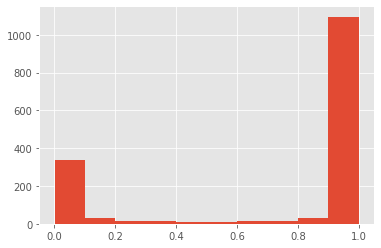

In [ ]:
model_early_predict = model_prediction(model_early)

True Positive Rate/Recall:  0.9829351535836177
True Negative Rate 0.9578163771712159
False Positive Rate:  0.04218362282878412
False Negative Rate:  0.017064846416382253
Accuracy:  0.9765079365079365
Precision:  0.9854576561163387
F1 Score: 0.9841947885519008
False Discovery Rate:  0.017064846416382253
Negative Predictive:  0.9507389162561576


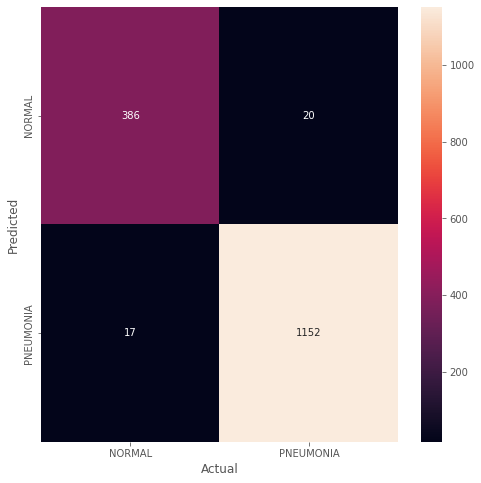

In [ ]:
evaluation_metrics(model_early_predict, 0.5)

True Positive Rate/Recall:  0.9764309764309764
True Negative Rate 0.9689922480620154
False Positive Rate:  0.031007751937984496
False Negative Rate:  0.02356902356902357
Accuracy:  0.9746031746031746
Precision:  0.9897610921501706
F1 Score: 0.9830508474576272
False Discovery Rate:  0.02356902356902357
Negative Predictive:  0.9305210918114144


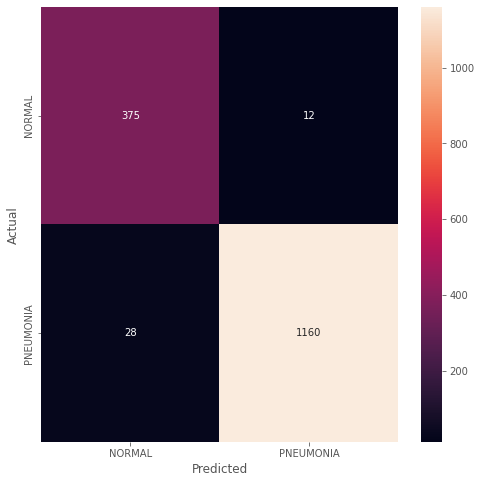

In [ ]:
evaluation_metrics(model_early_predict, 0.5)

True Positive Rate/Recall:  0.9905172413793103
True Negative Rate 0.944578313253012
False Positive Rate:  0.05542168674698795
False Negative Rate:  0.009482758620689655
Accuracy:  0.9784126984126984
Precision:  0.9803754266211604
F1 Score: 0.9854202401372213
False Discovery Rate:  0.009482758620689655
Negative Predictive:  0.9727047146401985


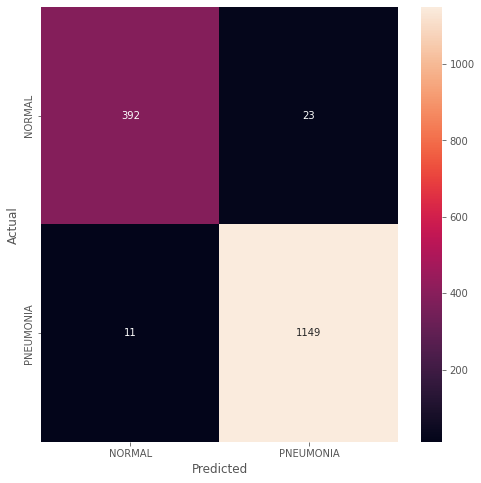

In [ ]:
evaluation_metrics(model_early_predict, 0.75)

#### Data Augmentation

Another common method used to reduce overfitting data augmentation to increase the size and variety of the dataset. 

##### Flips, Rotation, Zoom

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
data_augmentation_all = tf.keras.Sequential([
  layers.RandomFlip(),
  layers.RandomRotation(factor = (-1/12, 1/12)),      #rotation is controlled at clockwise/anticlockwise of 30 degrees
  layers.RandomZoom(width_factor=(-0.1,0.1), height_factor=(-0.1,0.1))    #zooms are also controlled at 10% to avoid creating cases of unlikely data
])

In [ ]:
#same architecture used
model_aug_all = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation_all,   #augmented data added here
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
model_aug_all.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 350, 3)       0         
                                                                 
 sequential (Sequential)     (None, 240, 350, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 350, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 175, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 175, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 87, 32)       0         
 2D)                                                  

In [ ]:
model_aug_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
model_aug_all_fit = model_aug_all.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 30, 
    callbacks = [earlystopping]
)

Epoch 1/30


115/115 [==============================] - 33s 241ms/step - loss: 0.5647 - accuracy: 0.7425 - val_loss: 0.5201 - val_accuracy: 0.7441
Epoch 2/30
115/115 [==============================] - 28s 244ms/step - loss: 0.4900 - accuracy: 0.7517 - val_loss: 0.4153 - val_accuracy: 0.7644
Epoch 3/30
115/115 [==============================] - 28s 240ms/step - loss: 0.4186 - accuracy: 0.8077 - val_loss: 0.3423 - val_accuracy: 0.8965
Epoch 4/30
115/115 [==============================] - 27s 235ms/step - loss: 0.3491 - accuracy: 0.8594 - val_loss: 0.3125 - val_accuracy: 0.9124
Epoch 5/30
115/115 [==============================] - 28s 248ms/step - loss: 0.3064 - accuracy: 0.8871 - val_loss: 0.2473 - val_accuracy: 0.9124
Epoch 6/30
115/115 [==============================] - 27s 236ms/step - loss: 0.2676 - accuracy: 0.9018 - val_loss: 0.2705 - val_accuracy: 0.9086
Epoch 7/30
115/115 [==============================] - 27s 236ms/step - loss: 0.2521 - accuracy: 0.9045 - val_loss: 0.2130 - val_accuracy: 0.9

In [ ]:
model_aug_all.save('drive/MyDrive/DSA4266/aug_all_model')

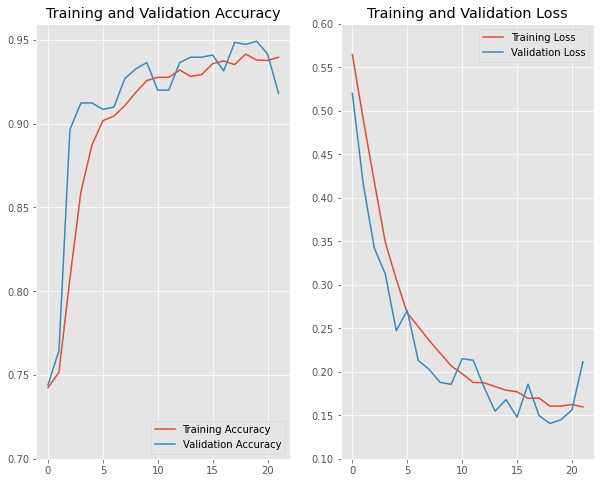

In [ ]:
plot_accuracy_loss(model_aug_all_fit)

It seems like overfitting may have been reduced, but the validation curves also seem to fluctuate a lot more throughout the training period. Furthermore, the overall performance of the model is also lower than the previous models.

50/50 [==============================] - 1s 20ms/step


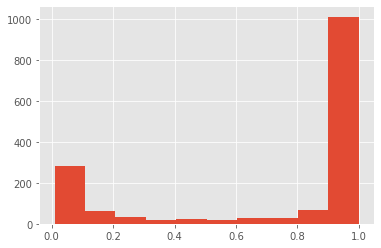

In [ ]:
model_aug_all_predict = model_prediction(model_aug_all)

The probability output distribution is also has significant frequences that are in between 0.1 and 0.9. 

True Positive Rate/Recall:  0.9573378839590444
True Negative Rate 0.9181141439205955
False Positive Rate:  0.08188585607940446
False Negative Rate:  0.042662116040955635
Accuracy:  0.9473015873015873
Precision:  0.9714285714285714
F1 Score: 0.9643317576278471
False Discovery Rate:  0.042662116040955635
Negative Predictive:  0.8809523809523809


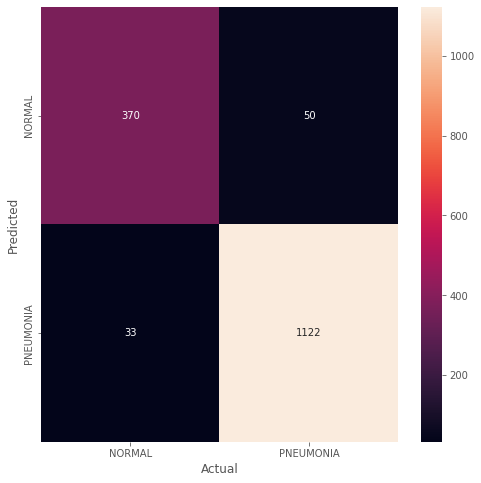

In [ ]:
evaluation_metrics(model_aug_all_predict, 0.5)

True Positive Rate/Recall:  0.9215017064846417
True Negative Rate 0.967741935483871
False Positive Rate:  0.03225806451612903
False Negative Rate:  0.07849829351535836
Accuracy:  0.9333333333333333
Precision:  0.9881061299176578
F1 Score: 0.9536423841059603
False Discovery Rate:  0.07849829351535836
Negative Predictive:  0.8091286307053942


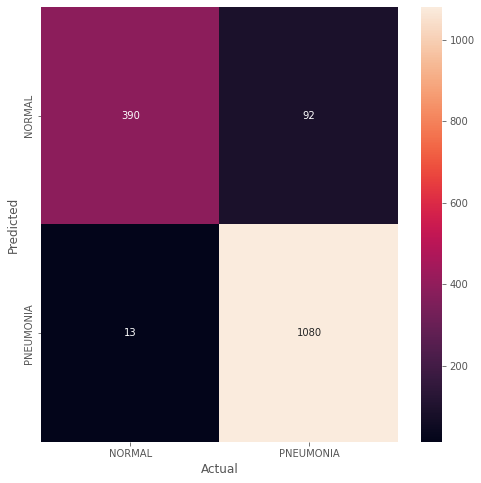

In [ ]:
evaluation_metrics(model_aug_all_predict, 0.75)

The evaluation metrics further reveal that indeed the model's performance signficantly worsened. One of the most likely reason could be the fact that horizontal/vertical flips create cases of very unlikely chest xrays because 
1) Horizontal flips also flips the location of the heart, which is always on the left (right on the xray). 
2) Vertical flips make the images upside down, but diagnosis is unlikely to be done upside down. 

##### Rotation and Zoom only

As such, we could once again try augmenting the data, but this time without perofrming any flips and only rotating and zooming the images. Note that the zooms and rotations are also controlled at a small amount to keep the new data points feasible/realistic.

In [ ]:
data_augmentation_no_flip = tf.keras.Sequential([
  layers.RandomRotation(factor = (-1/12, 1/12)),
  layers.RandomZoom(width_factor=(-0.1,0.1), height_factor=(-0.1,0.1))
])

In [ ]:
model_aug_no_flip = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation_no_flip,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
model_aug_no_flip.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

The frequency of probability outputs in the central area have also significantly increased. 

In [ ]:
model_aug_no_flip_fit = model_aug_no_flip.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 30
)

Epoch 1/30


115/115 [==============================] - 34s 249ms/step - loss: 0.5727 - accuracy: 0.7395 - val_loss: 0.5318 - val_accuracy: 0.7441
Epoch 2/30
115/115 [==============================] - 28s 242ms/step - loss: 0.5141 - accuracy: 0.7427 - val_loss: 0.4642 - val_accuracy: 0.7790
Epoch 3/30
115/115 [==============================] - 34s 299ms/step - loss: 0.4505 - accuracy: 0.7664 - val_loss: 0.3971 - val_accuracy: 0.8756
Epoch 4/30
115/115 [==============================] - 30s 262ms/step - loss: 0.3897 - accuracy: 0.8246 - val_loss: 0.3355 - val_accuracy: 0.8952
Epoch 5/30
115/115 [==============================] - 27s 232ms/step - loss: 0.3385 - accuracy: 0.8589 - val_loss: 0.3281 - val_accuracy: 0.8946
Epoch 6/30
115/115 [==============================] - 27s 236ms/step - loss: 0.3006 - accuracy: 0.8855 - val_loss: 0.2511 - val_accuracy: 0.9054
Epoch 7/30
115/115 [==============================] - 27s 234ms/step - loss: 0.2744 - accuracy: 0.8950 - val_loss: 0.2339 - val_accuracy: 0.9

In [ ]:
model_aug_no_flip.save('drive/MyDrive/DSA4266/aug_no_flip_model')

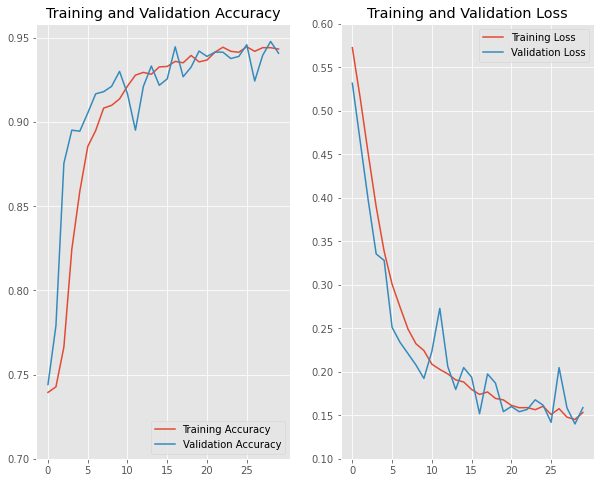

In [ ]:
plot_accuracy_loss(model_aug_no_flip_fit)

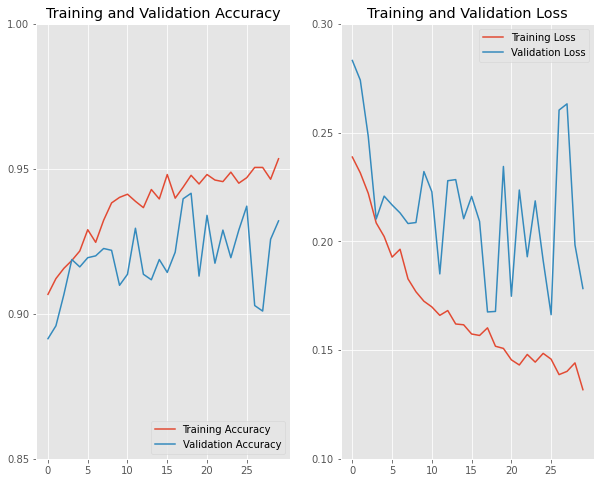

In [ ]:
plot_accuracy_loss(model_aug_no_flip_fit)

Although the validation curves have a slightly better performance after removing random flips, the trends of the validation curve fluctuate a lot more. 

50/50 [==============================] - 1s 20ms/step


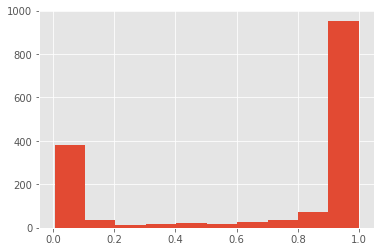

In [ ]:
model_aug_no_flip_predict = model_prediction(model_aug_no_flip)

50/50 [==============================] - 1s 27ms/step


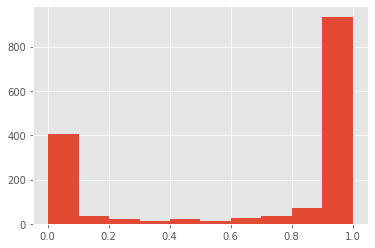

In [ ]:
model_aug_no_flip_predict = model_prediction(model_aug_no_flip)

True Positive Rate/Recall:  0.931740614334471
True Negative Rate 0.967741935483871
False Positive Rate:  0.03225806451612903
False Negative Rate:  0.06825938566552901
Accuracy:  0.940952380952381
Precision:  0.9882352941176471
F1 Score: 0.9591567852437419
False Discovery Rate:  0.06825938566552901
Negative Predictive:  0.8297872340425532


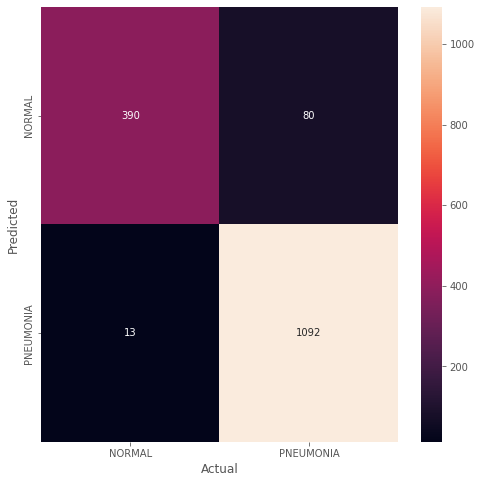

In [ ]:
evaluation_metrics(model_aug_no_flip_predict, 0.5)

True Positive Rate/Recall:  0.9925994449583718
True Negative Rate 0.7995951417004049
False Positive Rate:  0.20040485829959515
False Negative Rate:  0.0074005550416281225
Accuracy:  0.932063492063492
Precision:  0.9155290102389079
F1 Score: 0.9525077674212161
False Discovery Rate:  0.0074005550416281225
Negative Predictive:  0.9801488833746899


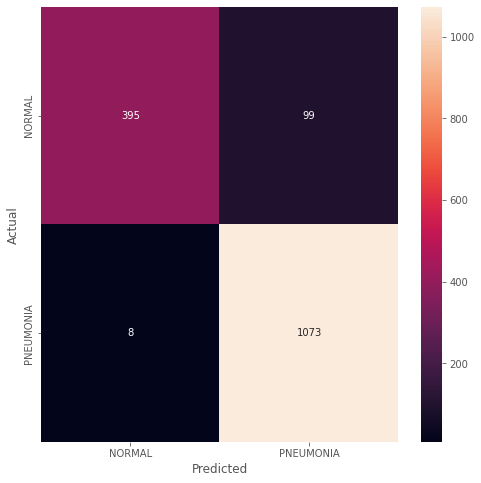

In [ ]:
evaluation_metrics(model_aug_no_flip_predict, 0.5)

True Positive Rate/Recall:  0.9961013645224172
True Negative Rate 0.726775956284153
False Positive Rate:  0.273224043715847
False Negative Rate:  0.003898635477582846
Accuracy:  0.9022222222222223
Precision:  0.8720136518771331
F1 Score: 0.9299363057324842
False Discovery Rate:  0.003898635477582846
Negative Predictive:  0.9900744416873449


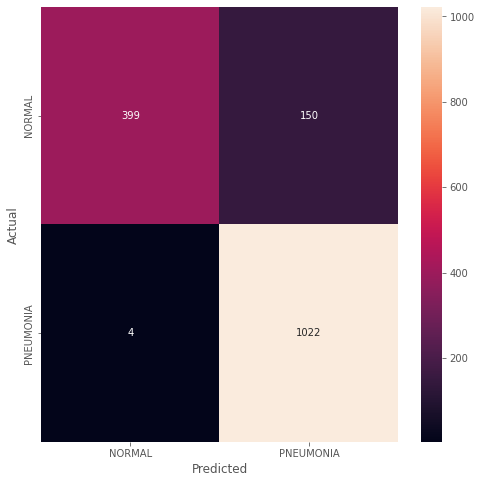

In [ ]:
evaluation_metrics(model_aug_no_flip_predict, 0.75)

The evaluation metrics show that 

As a result, data augmentation of any form is not a suitable method of reducing overfitting for our given dataset. 

#### Regularization

Next, we also try regularization. This method aims to increase the variation of the dataset (and add some amount of noise), so that the model can perform better on unseen data. 

We may try L1 regularization as well, but L2 regularization is usually more effective in reducing overfitting (as it uses L2 norm to increase the signficance on the tails/outliers and reduce codependencies). 

##### L1 Regularization

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model_l1 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l1(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l1(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l1(0.001)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
model_l1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 240, 350, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 350, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 120, 175, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 175, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 60, 87, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 87, 64)       

In [ ]:
model_l1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [ ]:
model_l1_fit = model_l1.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 30, 
    callbacks = [earlystopping]
)

Epoch 1/30
115/115 [==============================] - 45s 76ms/step - loss: 1.6292 - accuracy: 0.7373 - val_loss: 1.5699 - val_accuracy: 0.7441
Epoch 2/30
115/115 [==============================] - 9s 76ms/step - loss: 1.5200 - accuracy: 0.7476 - val_loss: 1.4627 - val_accuracy: 0.8171
Epoch 3/30
115/115 [==============================] - 8s 72ms/step - loss: 1.4112 - accuracy: 0.8232 - val_loss: 1.3587 - val_accuracy: 0.8622
Epoch 4/30
115/115 [==============================] - 8s 70ms/step - loss: 1.3198 - accuracy: 0.8939 - val_loss: 1.2811 - val_accuracy: 0.8914
Epoch 5/30
115/115 [==============================] - 8s 72ms/step - loss: 1.2495 - accuracy: 0.9146 - val_loss: 1.2315 - val_accuracy: 0.8978
Epoch 6/30
115/115 [==============================] - 8s 71ms/step - loss: 1.1962 - accuracy: 0.9252 - val_loss: 1.1770 - val_accuracy: 0.9187
Epoch 7/30
115/115 [==============================] - 8s 71ms/step - loss: 1.1473 - accuracy: 0.9372 - val_loss: 1.1312 - val_accuracy: 0.943

In [ ]:
model_l1.save('drive/MyDrive/DSA4266/l1_reg_model')

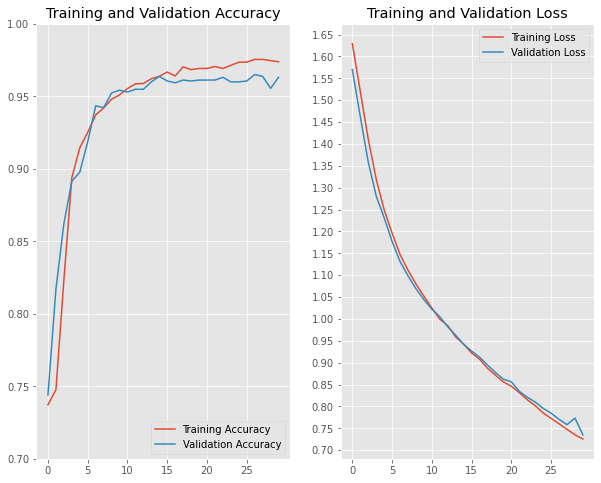

In [ ]:
plot_accuracy_loss(model_l1_fit)

50/50 [==============================] - 1s 27ms/step


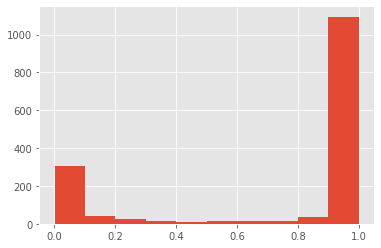

In [ ]:
model_l1_predict = model_prediction(model_l1)

L1 regularization results in a much smoother 

##### L2 Regularization

True Positive Rate/Recall:  0.9728353140916808
True Negative Rate 0.9345088161209067
False Positive Rate:  0.0654911838790932
False Negative Rate:  0.027164685908319185
Accuracy:  0.9631746031746031
Precision:  0.9778156996587031
F1 Score: 0.9753191489361701
False Discovery Rate:  0.027164685908319185
Negative Predictive:  0.9205955334987593


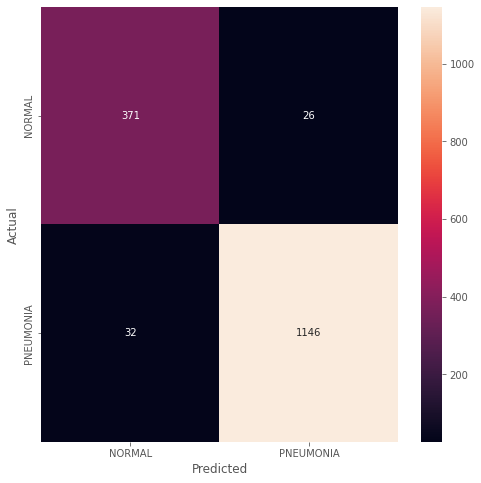

In [ ]:
evaluation_metrics(model_l1_predict, 0.5)

True Positive Rate/Recall:  0.9894459102902374
True Negative Rate 0.8926940639269406
False Positive Rate:  0.10730593607305935
False Negative Rate:  0.010554089709762533
Accuracy:  0.9625396825396826
Precision:  0.9598976109215017
F1 Score: 0.97444781290602
False Discovery Rate:  0.010554089709762533
Negative Predictive:  0.9702233250620348


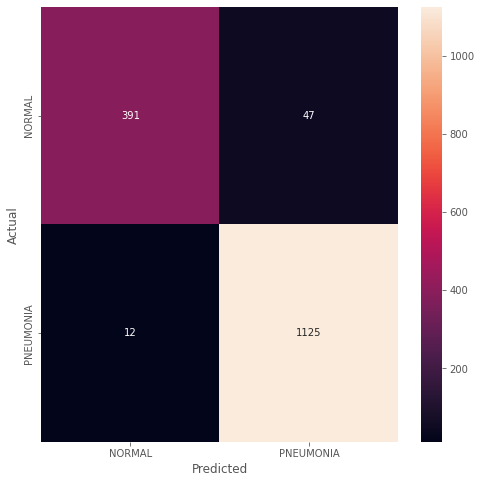

In [ ]:
evaluation_metrics(model_l1_predict, 0.75)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model_l2 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
model_l2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=['accuracy'])

In [ ]:
model_l2_fit = model_l2.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 30, 
    callbacks = [earlystopping]
)

Epoch 1/30
115/115 [==============================] - 9s 57ms/step - loss: 0.6087 - accuracy: 0.7427 - val_loss: 0.5329 - val_accuracy: 0.7448
Epoch 2/30
115/115 [==============================] - 6s 52ms/step - loss: 0.4684 - accuracy: 0.8091 - val_loss: 0.4082 - val_accuracy: 0.8279
Epoch 3/30
115/115 [==============================] - 6s 53ms/step - loss: 0.3622 - accuracy: 0.8942 - val_loss: 0.3208 - val_accuracy: 0.9073
Epoch 4/30
115/115 [==============================] - 6s 52ms/step - loss: 0.2940 - accuracy: 0.9184 - val_loss: 0.2726 - val_accuracy: 0.9333
Epoch 5/30
115/115 [==============================] - 7s 59ms/step - loss: 0.2514 - accuracy: 0.9377 - val_loss: 0.2461 - val_accuracy: 0.9295
Epoch 6/30
115/115 [==============================] - 6s 53ms/step - loss: 0.2215 - accuracy: 0.9459 - val_loss: 0.2157 - val_accuracy: 0.9479
Epoch 7/30
115/115 [==============================] - 7s 57ms/step - loss: 0.1993 - accuracy: 0.9538 - val_loss: 0.2015 - val_accuracy: 0.9543

In [ ]:
model_l2.save('drive/MyDrive/DSA4266/l2_reg_model')

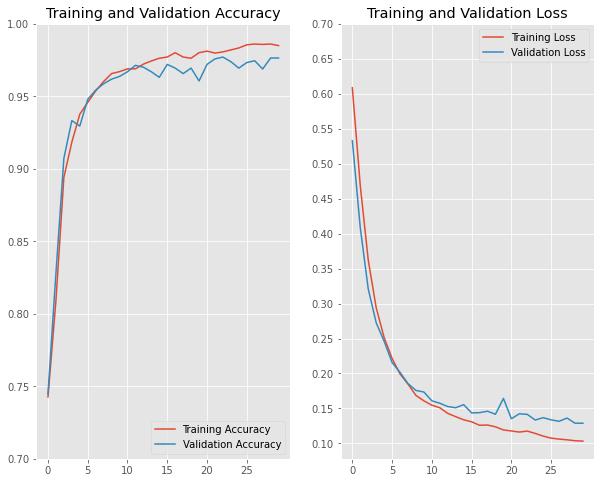

In [ ]:
plot_accuracy_loss(model_l2_fit)

50/50 [==============================] - 1s 19ms/step


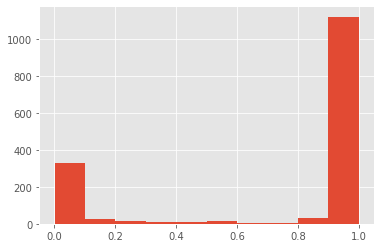

In [ ]:
model_l2_predict = model_prediction(model_l2)

True Positive Rate/Recall:  0.9880546075085325
True Negative Rate 0.9429280397022333
False Positive Rate:  0.05707196029776675
False Negative Rate:  0.011945392491467578
Accuracy:  0.9765079365079365
Precision:  0.9805249788314987
F1 Score: 0.9842753931151721
False Discovery Rate:  0.011945392491467578
Negative Predictive:  0.9644670050761421


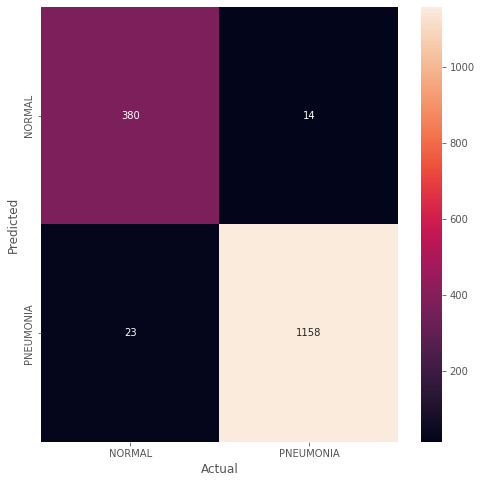

In [ ]:
evaluation_metrics(model_l2_predict, 0.5)

True Positive Rate/Recall:  0.9904679376083189
True Negative Rate 0.9311163895486936
False Positive Rate:  0.0688836104513064
False Negative Rate:  0.009532062391681109
Accuracy:  0.9746031746031746
Precision:  0.9752559726962458
F1 Score: 0.9828030954428203
False Discovery Rate:  0.009532062391681109
Negative Predictive:  0.9727047146401985


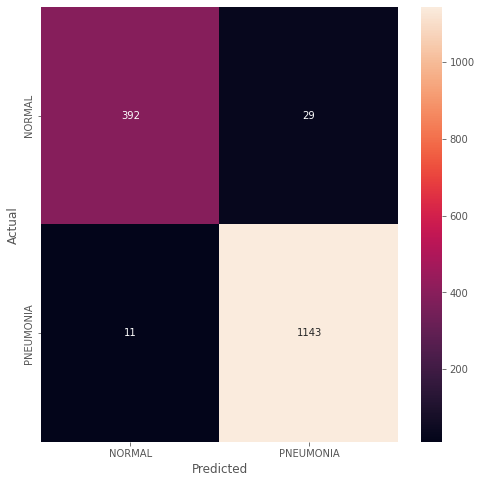

In [ ]:
evaluation_metrics(model_l2_predict, 0.75)

#### Batch Normalization

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model_norm = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
model_norm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 350, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 350, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 240, 350, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 175, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 175, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 120, 175, 32)     1

In [ ]:
model_norm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy'])

In [ ]:
model_norm_fit = model_norm.fit(
    train_ds, 
    validation_data = test_ds, 
    epochs = 30, 
    callbacks = [earlystopping]
)

Epoch 1/30
115/115 [==============================] - 12s 79ms/step - loss: 0.2163 - accuracy: 0.9402 - val_loss: 0.6674 - val_accuracy: 0.7441
Epoch 2/30
115/115 [==============================] - 8s 69ms/step - loss: 0.1061 - accuracy: 0.9859 - val_loss: 0.9157 - val_accuracy: 0.7441
Epoch 3/30
115/115 [==============================] - 8s 70ms/step - loss: 0.0833 - accuracy: 0.9973 - val_loss: 0.8132 - val_accuracy: 0.7486
Epoch 4/30
115/115 [==============================] - 8s 69ms/step - loss: 0.0759 - accuracy: 0.9997 - val_loss: 0.3287 - val_accuracy: 0.8794
Epoch 5/30
115/115 [==============================] - 8s 70ms/step - loss: 0.0729 - accuracy: 1.0000 - val_loss: 0.1756 - val_accuracy: 0.9606
Epoch 6/30
115/115 [==============================] - 8s 70ms/step - loss: 0.0716 - accuracy: 1.0000 - val_loss: 0.1458 - val_accuracy: 0.9765
Epoch 7/30
115/115 [==============================] - 8s 70ms/step - loss: 0.0706 - accuracy: 1.0000 - val_loss: 0.1381 - val_accuracy: 0.979

In [ ]:
model_norm.save('drive/MyDrive/DSA4266/norm_model')

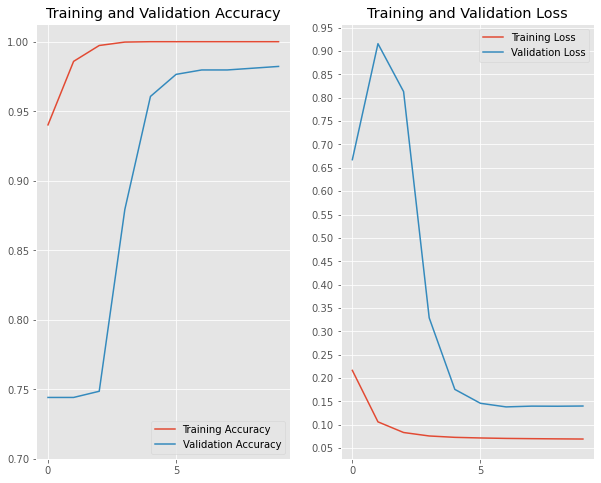

In [ ]:
plot_accuracy_loss(model_norm_fit)

50/50 [==============================] - 1s 22ms/step


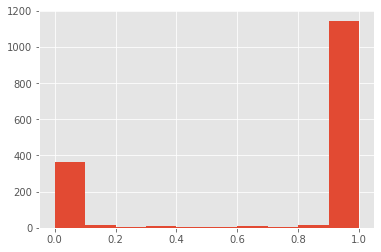

In [ ]:
model_norm_predict = model_prediction(model_norm)

True Positive Rate/Recall:  0.9897610921501706
True Negative Rate 0.9503722084367245
False Positive Rate:  0.04962779156327544
False Negative Rate:  0.010238907849829351
Accuracy:  0.9796825396825397
Precision:  0.9830508474576272
F1 Score: 0.9863945578231292
False Discovery Rate:  0.010238907849829351
Negative Predictive:  0.9696202531645569


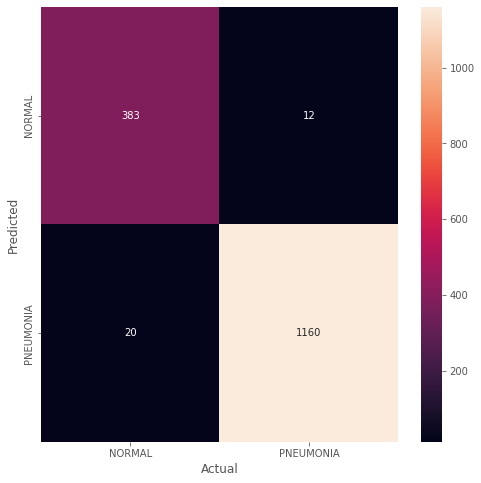

In [ ]:
evaluation_metrics(model_norm_predict, 0.5)

True Positive Rate/Recall:  0.9897172236503856
True Negative Rate 0.9583333333333334
False Positive Rate:  0.041666666666666664
False Negative Rate:  0.010282776349614395
Accuracy:  0.9815873015873016
Precision:  0.985494880546075
F1 Score: 0.9876015391192817
False Discovery Rate:  0.010282776349614395
Negative Predictive:  0.9702233250620348


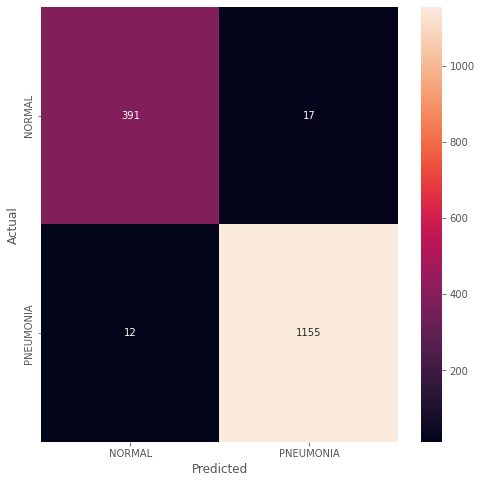

In [ ]:
evaluation_metrics(model_norm_predict, 0.75)

### Optimization

#### Hyperparameter Tuning (includes Dropout)

The first optimization method we will try is to fine tune the model parameters. This can be done by performing a parameter search. The following parameters will be experimented: 
1) Filter & Kernel Size, 2) Dropout rate, 3) Dense Layer Units, 4) Learning Rate

In [ ]:
tf.keras.backend.clear_session()

##### Base Model

We start by tuning our base model first (without any batch normalization or L2 regularization)



In [ ]:
## define a function that returns a model with the parameters and values to be tested 
def build_model(hp): 
  #model layer is built with some of the parameters containing a range of values for the parameter search
  model = Sequential([
      layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)), 
      layers.Conv2D(
          filters=hp.Int('conv_filter_1', min_value=32, max_value=128, step=16),    #hp Choice and hp Int are used to denote the parameter value choices 
          kernel_size=hp.Choice('conv_kernel_1', values = [3,5]),
          activation= 'relu'
      ), 
      layers.MaxPooling2D(), 
      layers.Conv2D(
          filters=hp.Int('conv_filter_2', min_value=32, max_value=128, step=16),
          kernel_size=hp.Choice('conv_kernel_2', values = [3,5]),
          activation= 'relu'
      ), 
      layers.MaxPooling2D(), 
      layers.Conv2D(
          filters=hp.Int('conv_filter_3', min_value=32, max_value=128, step=16),
          kernel_size=hp.Choice('conv_kernel_3', values = [3,5]),
          activation= 'relu'
      ), 
      layers.MaxPooling2D(),
      layers.Flatten(), 
      layers.Dropout(                                                                 #Dropout layer included to allow model to learn independent representations and improve performance
          rate = hp.Choice('dropout_rate', values = [0.1, 0.2, 0.3, 0.4, 0.5])
      ),
      layers.Dense(
          units = hp.Int('dense_units', min_value=32, max_value=512, step=32), 
          activation = 'relu'
      ), 
      layers.Dense(1, activation='sigmoid')

  ])

  hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001])   #learning rate choice

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),              #compiling the model
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [ ]:
#early stopping is used to stop the parameter search early if a certain combination seems to be perform worse across the epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)     #validation loss is monitored to check whether it is constantly increasing for more than 2 epochs

Bayesian Optimiztion to allow the search to leverage on probability to converge towards better performing parameter/parameter combinations. This would allow us to save time on trying out models that will obviously not perform well and hence be able to get better results in fewer trials. 

In [ ]:
tuner = kt.BayesianOptimization(build_model,
                     objective='val_accuracy',
                     max_trials = 30)         #trial limit is set at 30 models (this would take 1-2 hours) so that the runtime doesn't crash

In [ ]:
## warning, takes a long time to run!
tuner.search(train_ds, validation_data=test_ds, epochs = 10, callbacks=[stop_early])    #at each trial, the model is trained for 10 epocs

Trial 30 Complete [00h 05m 23s]
val_accuracy: 0.9549206495285034

Best val_accuracy So Far: 0.9777777791023254
Total elapsed time: 01h 26m 34s


In [ ]:
## parameters of the best performing model in the tuner search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""First Conv2D: {best_hps.get('conv_filter_1')}, {best_hps.get('conv_kernel_1')}""")
print(f"""Second Conv2D: {best_hps.get('conv_filter_2')}, {best_hps.get('conv_kernel_2')}""")
print(f"""Third Conv2D: {best_hps.get('conv_filter_3')}, {best_hps.get('conv_kernel_3')}""")
print(f"""Dropout Rate: {best_hps.get('dropout_rate')}""")
print(f"""Dense Unit: {best_hps.get('dense_units')}""")
print(f"""Learning Rate: {best_hps.get('learning_rate')}""")

First Conv2D: 48, 3
Second Conv2D: 112, 5
Third Conv2D: 32, 3
Dropout Rate: 0.3
Dense Unit: 192
Learning Rate: 0.0001


In [ ]:
hyper_model = tuner.hypermodel.build(best_hps)
hyper_model_fit = hyper_model.fit(train_ds, epochs=30, validation_data = test_ds, callbacks = [earlystopping]) 

Epoch 1/30
115/115 [==============================] - 13s 104ms/step - loss: 0.3815 - accuracy: 0.8389 - val_loss: 0.1862 - val_accuracy: 0.9222
Epoch 2/30
115/115 [==============================] - 12s 103ms/step - loss: 0.1289 - accuracy: 0.9509 - val_loss: 0.1002 - val_accuracy: 0.9630
Epoch 3/30
115/115 [==============================] - 12s 102ms/step - loss: 0.0981 - accuracy: 0.9653 - val_loss: 0.0867 - val_accuracy: 0.9662
Epoch 4/30
115/115 [==============================] - 12s 102ms/step - loss: 0.0896 - accuracy: 0.9645 - val_loss: 0.0800 - val_accuracy: 0.9681
Epoch 5/30
115/115 [==============================] - 12s 101ms/step - loss: 0.0703 - accuracy: 0.9743 - val_loss: 0.1225 - val_accuracy: 0.9611
Epoch 6/30
115/115 [==============================] - 12s 101ms/step - loss: 0.0596 - accuracy: 0.9779 - val_loss: 0.1443 - val_accuracy: 0.9509
Epoch 7/30
115/115 [==============================] - 12s 103ms/step - loss: 0.0610 - accuracy: 0.9782 - val_loss: 0.0742 - val_ac

In [ ]:
hyper_model.save('drive/MyDrive/DSA4266/hyper_base_model')

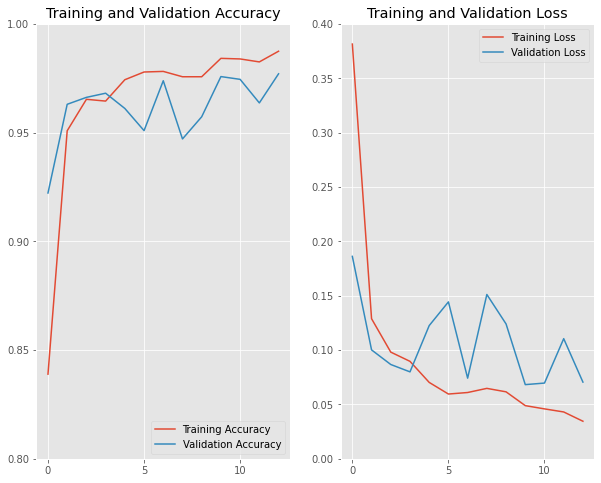

In [ ]:
plot_accuracy_loss(hyper_model_fit)

50/50 [==============================] - 2s 39ms/step


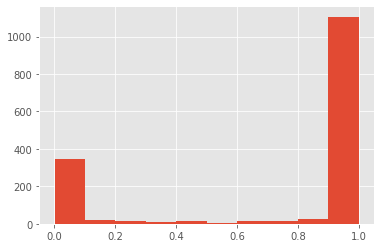

In [ ]:
hyper_model_predict = model_prediction(hyper_model)

True Positive Rate/Recall:  0.9820819112627986
True Negative Rate 0.9602977667493796
False Positive Rate:  0.03970223325062035
False Negative Rate:  0.017918088737201365
Accuracy:  0.9765079365079365
Precision:  0.9862896315338475
F1 Score: 0.9841812740487389
False Discovery Rate:  0.017918088737201365
Negative Predictive:  0.9485294117647058


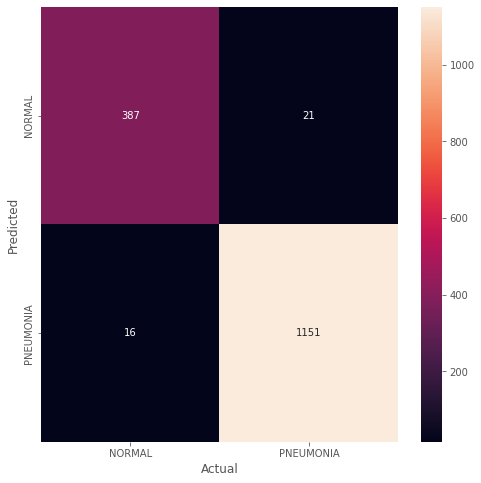

In [ ]:
evaluation_metrics(hyper_model_predict, 0.5)

Interestingly, fine tuning the base model did not increase the performance from the pre-tuned base model. This could have possibly occured simply due to randomness in the examples or perhaps stopping the tuner search at fewer trials. 


One of the ways to avoid this could be to narrow down our choice of parameters. 
Based on the observations of the previous tuner search run: 
1) kernel pattern of 3-5-3 worked better
2) higher droupout rates worked better (0.3 or more)
3) higher dense units worked better (350 or more)
4) lower learning rates worked better (at most 0.0001)

##### With Batch Normalization

With the insights above, we could narrow down our parameter search space and this time include the normalization layers to experiment if that stabilizes the validation performance across the training period.  

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def build_model_norm(hp): 
  model = Sequential([
      layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)), 
      layers.Conv2D(
          filters=hp.Int('conv_filter_1', min_value=32, max_value=128, step=16),
          kernel_size=hp.Choice('conv_kernel_1', values = [3,5]),
          activation= 'relu'
      ), 
      layers.BatchNormalization(),
      layers.MaxPooling2D(), 
      layers.Conv2D(
          filters=hp.Int('conv_filter_2', min_value=32, max_value=128, step=16),
          kernel_size=hp.Choice('conv_kernel_2', values = [3,5]),
          activation= 'relu'
      ), 
      layers.BatchNormalization(),
      layers.MaxPooling2D(), 
      layers.Conv2D(
          filters=hp.Int('conv_filter_3', min_value=32, max_value=128, step=16),
          kernel_size=hp.Choice('conv_kernel_3', values = [3,5]),
          activation= 'relu'
      ), 
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Flatten(), 
      layers.Dropout(
          rate = hp.Choice('dropout_rate', values = [0.3, 0.4, 0.5])
      ),
      layers.Dense(
          units = hp.Int('dense_units', min_value=384, max_value=512, step=32), 
          activation = 'relu'
      ), 
      layers.Dense(1, activation='sigmoid')

  ])

  hp_learning_rate = hp.Choice('learning_rate', values= [0.0001, 0.00001])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

This time we will be reducing the number of trials as the parameter search have also narrowed down. This will also save us time on the parameter search.

In [ ]:
tuner_norm = kt.BayesianOptimization(build_model_norm,
                     objective='val_accuracy',
                     max_trials = 20, 
                     overwrite = True)

In [ ]:
tuner_norm.search(train_ds, epochs=10, validation_data=test_ds, callbacks=[stop_early])

Trial 20 Complete [00h 01m 56s]
val_accuracy: 0.7441269755363464

Best val_accuracy So Far: 0.9828571677207947
Total elapsed time: 00h 39m 50s


In [ ]:
best_hps_norm = tuner_norm.get_best_hyperparameters(num_trials=1)[0]

print(f"""First Conv2D: {best_hps_norm.get('conv_filter_1')}, {best_hps_norm.get('conv_kernel_1')}""")
print(f"""Second Conv2D: {best_hps_norm.get('conv_filter_2')}, {best_hps_norm.get('conv_kernel_2')}""")
print(f"""Third Conv2D: {best_hps_norm.get('conv_filter_3')}, {best_hps_norm.get('conv_kernel_3')}""")
print(f"""Dropout Rate: {best_hps_norm.get('dropout_rate')}""")
print(f"""Dense Unit: {best_hps_norm.get('dense_units')}""")
print(f"""Learning Rate: {best_hps_norm.get('learning_rate')}""")

First Conv2D: 112, 3
Second Conv2D: 32, 5
Third Conv2D: 96, 3
Dropout Rate: 0.5
Dense Unit: 448
Learning Rate: 1e-05


The optimal parameters that are  outputted have changed

In [ ]:
hyper_model_norm = tuner_norm.hypermodel.build(best_hps_norm)
hyper_model_norm_fit = hyper_model_norm.fit(train_ds, epochs=50, validation_data = test_ds, callbacks = [earlystopping]) 

Epoch 1/50
115/115 [==============================] - 653s 5s/step - loss: 0.1943 - accuracy: 0.9347 - val_loss: 0.7575 - val_accuracy: 0.7441
Epoch 2/50
115/115 [==============================] - 46s 386ms/step - loss: 0.0593 - accuracy: 0.9769 - val_loss: 1.3262 - val_accuracy: 0.7441
Epoch 3/50
115/115 [==============================] - 45s 376ms/step - loss: 0.0381 - accuracy: 0.9861 - val_loss: 1.2700 - val_accuracy: 0.7441
Epoch 4/50
115/115 [==============================] - 47s 393ms/step - loss: 0.0206 - accuracy: 0.9927 - val_loss: 0.4670 - val_accuracy: 0.8229
Epoch 5/50
115/115 [==============================] - 46s 384ms/step - loss: 0.0122 - accuracy: 0.9970 - val_loss: 0.3221 - val_accuracy: 0.8952
Epoch 6/50
115/115 [==============================] - 46s 385ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 0.1134 - val_accuracy: 0.9657
Epoch 7/50
115/115 [==============================] - 56s 477ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0900 - val_accu

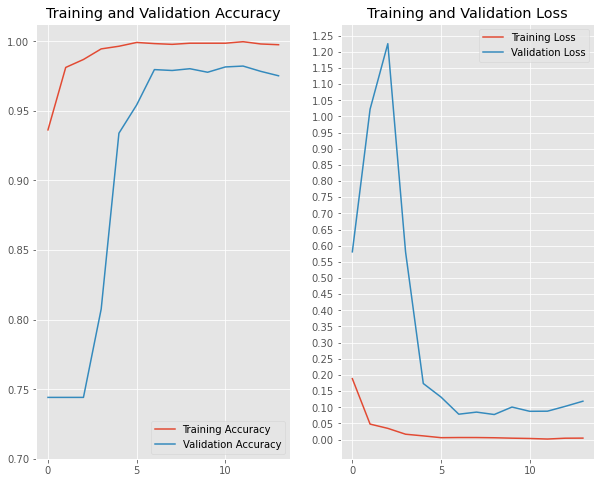

In [ ]:
plot_accuracy_loss(hyper_model_norm_fit)

50/50 [==============================] - 3s 63ms/step


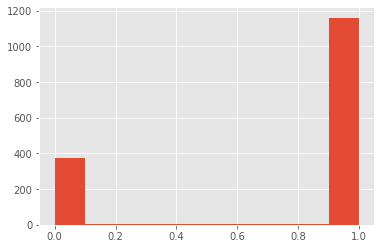

In [ ]:
hyper_model_norm_predict = model_prediction(hyper_model_norm)

True Positive Rate/Recall:  0.9906143344709898
True Negative Rate 0.9602977667493796
False Positive Rate:  0.03970223325062035
False Negative Rate:  0.00938566552901024
Accuracy:  0.9828571428571429
Precision:  0.9864061172472387
F1 Score: 0.9885057471264368
False Discovery Rate:  0.00938566552901024
Negative Predictive:  0.9723618090452262


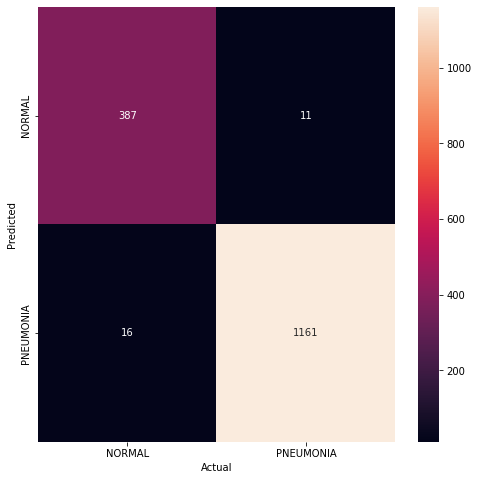

In [ ]:
evaluation_metrics(hyper_model_norm_predict, 0.5)

We observe that this model definitely performs better than the hypertuned base model. Hence, the normalization layers will be kept for the final model. Furthermore, the model seems to be more stabilized. 

In [ ]:
hyper_model_norm.save('drive/MyDrive/DSA4266/hyper_model_norm')

##### With Batch Normalization and L2 Regularization

Finally, we can add the L2 Regularization layer along to along with the fine tuned model with normalization layers and evaluate if performance increases. 

The same parameter combination will be used. Hence, we created a separate model to help us.  

In [ ]:
tf.keras.backend.clear_session()

In [16]:
### for visualization
hyper_model_norm_l2 = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 5, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(96, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(448, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
hyper_model_norm_l2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [ ]:
hyper_model_norm_l2_fit = hyper_model_norm_l2.fit(train_ds, validation_data = test_ds, epochs = 30, callbacks = [earlystopping])

Epoch 1/30
115/115 [==============================] - 34s 258ms/step - loss: 0.3264 - accuracy: 0.9315 - val_loss: 0.8911 - val_accuracy: 0.7441
Epoch 2/30
115/115 [==============================] - 28s 240ms/step - loss: 0.1541 - accuracy: 0.9826 - val_loss: 1.1880 - val_accuracy: 0.7441
Epoch 3/30
115/115 [==============================] - 28s 246ms/step - loss: 0.1330 - accuracy: 0.9886 - val_loss: 0.8683 - val_accuracy: 0.7454
Epoch 4/30
115/115 [==============================] - 31s 269ms/step - loss: 0.1179 - accuracy: 0.9940 - val_loss: 0.7244 - val_accuracy: 0.7975
Epoch 5/30
115/115 [==============================] - 28s 247ms/step - loss: 0.1108 - accuracy: 0.9973 - val_loss: 0.2406 - val_accuracy: 0.9448
Epoch 6/30
115/115 [==============================] - 29s 250ms/step - loss: 0.1115 - accuracy: 0.9970 - val_loss: 0.2119 - val_accuracy: 0.9638
Epoch 7/30
115/115 [==============================] - 29s 251ms/step - loss: 0.1088 - accuracy: 0.9978 - val_loss: 0.1626 - val_ac

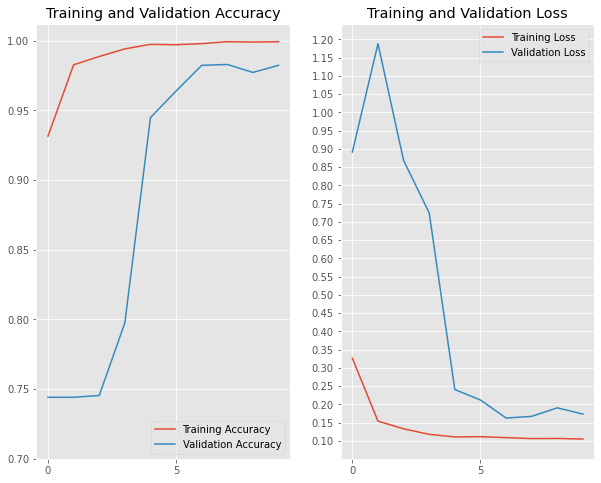

In [ ]:
plot_accuracy_loss(hyper_model_norm_l2_fit)

50/50 [==============================] - 3s 55ms/step


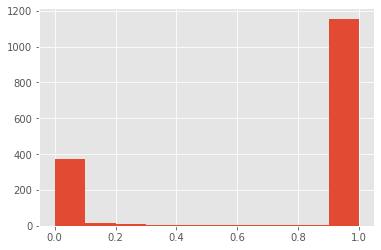

In [ ]:
hyper_model_norm_l2_predict = model_prediction(hyper_model_norm_l2)

True Positive Rate/Recall:  0.9889078498293515
True Negative Rate 0.9627791563275434
False Positive Rate:  0.03722084367245657
False Negative Rate:  0.011092150170648464
Accuracy:  0.9822222222222222
Precision:  0.9872231686541738
F1 Score: 0.9880647911338448
False Discovery Rate:  0.011092150170648464
Negative Predictive:  0.9675810473815462


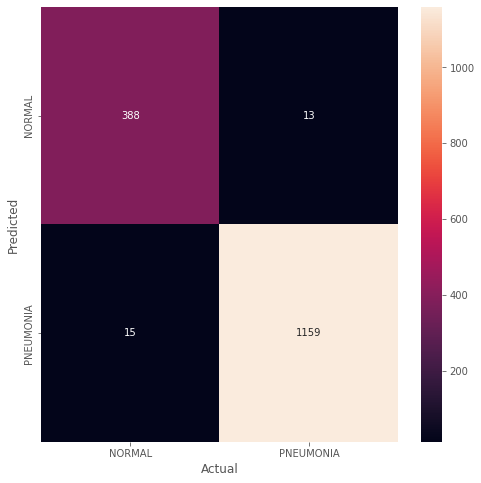

In [ ]:
evaluation_metrics(hyper_model_norm_l2_predict, 0.5)

This model also performs extemely well. However, since we would like to prioritize FNR as well as the stability of our model, regularization does not seem to be suitable. As such, the fine tuned normalized model is selected, which is enough to mitigate overfitting while improving the model performance. 

In [ ]:
hyper_model_norm_l2.save('drive/MyDrive/DSA4266/hyper_model_norm_l2')

#### Learning Rate Decay

Another technique to improve optimization is a learning rate decay. Having an adaptive learning rate that decrease as we progress through the training period allows the algorithm to find global minimizers (instead of getting stuck in local minimizers. 

However, based on the observations seen in parameter search, the model performed significantly better with lower learning rates in the trial runs. Hence, it we hypothesize that learning rate decay may not be necessary, but we can still verify this notion. 

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
final_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(96, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(448, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

In [ ]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=['accuracy', 'AUC'])

An exponential decay is used for the learning rate. There is no decrease in the first 5 epochs, but after the rate decreases exponentialy by a factor of 0.1. Note that the starting learning is kept at slightly higher of 0.001. 

In [ ]:
#exponential decay for learning
def exp_decay(epoch, lr):
  if epoch < 5:       #first 5 epochs constant
     return lr
  else:               #exponential decay after 5 epochs
    return lr * tf.math.exp(-0.1)
lrate = LearningRateScheduler(exp_decay)

In [ ]:
final_model_fit = final_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30, 
    callbacks = [earlystopping, lrate]
)

Epoch 1/30
115/115 [==============================] - 35s 278ms/step - loss: 1.3741 - accuracy: 0.9159 - auc: 0.9385 - val_loss: 0.2158 - val_accuracy: 0.9382 - val_auc: 0.9753 - lr: 0.0010
Epoch 2/30
115/115 [==============================] - 31s 266ms/step - loss: 0.1484 - accuracy: 0.9536 - auc: 0.9860 - val_loss: 2.8358 - val_accuracy: 0.4978 - val_auc: 0.8519 - lr: 0.0010
Epoch 3/30
115/115 [==============================] - 31s 269ms/step - loss: 0.0753 - accuracy: 0.9754 - auc: 0.9959 - val_loss: 0.1526 - val_accuracy: 0.9382 - val_auc: 0.9957 - lr: 0.0010
Epoch 4/30
115/115 [==============================] - 33s 287ms/step - loss: 0.0491 - accuracy: 0.9828 - auc: 0.9967 - val_loss: 0.0916 - val_accuracy: 0.9681 - val_auc: 0.9955 - lr: 0.0010
Epoch 5/30
115/115 [==============================] - 31s 268ms/step - loss: 0.0336 - accuracy: 0.9874 - auc: 0.9991 - val_loss: 0.1202 - val_accuracy: 0.9592 - val_auc: 0.9952 - lr: 0.0010
Epoch 6/30
115/115 [==============================

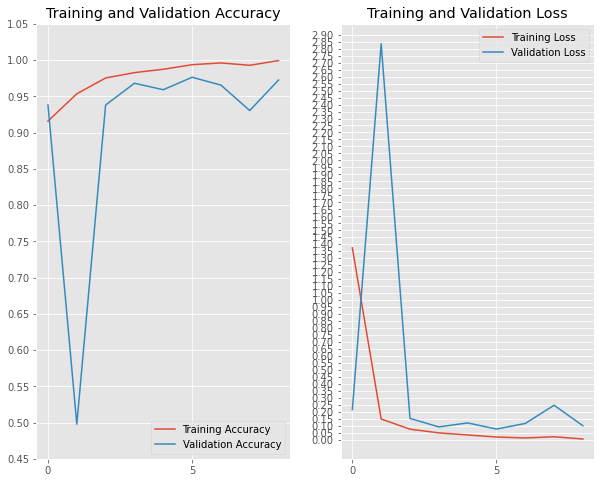

In [ ]:
plot_accuracy_loss(x_model2_fit)

50/50 [==============================] - 3s 61ms/step


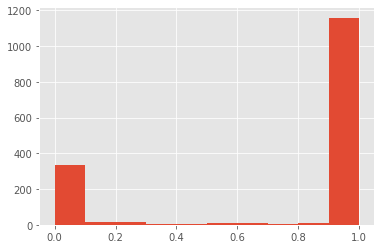

In [ ]:
x_model2_predict = model_prediction(x_model)

True Positive Rate/Recall:  0.9931682322801024
True Negative Rate 0.9271356783919598
False Positive Rate:  0.0728643216080402
False Negative Rate:  0.006831767719897523
Accuracy:  0.9764181007010835
Precision:  0.9756711409395973
F1 Score: 0.9843419382141346
False Discovery Rate:  0.006831767719897523
Negative Predictive:  0.9787798408488063


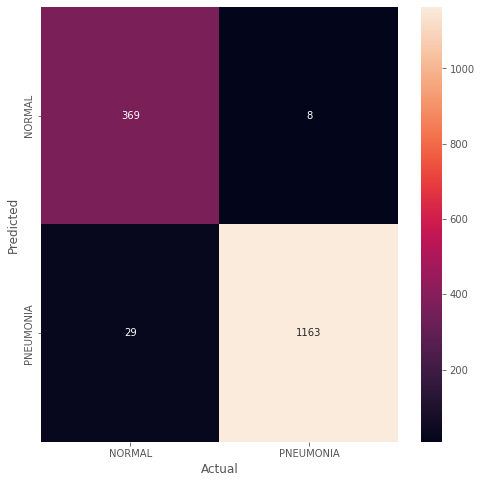

In [ ]:
evaluation_metrics(x_model2_predict, 0.5)

While the model converges faster and the FNR decreases by a significant amount, the model still doesn't seem to optimal and as stable. This is most likely because decaying from a higher learning rate is still not useful for this case as the optimization problem is most likely steep (due to a clean dataset). Hence, a constant learning rate of 0.00001 as found in the fine tuning stage will be maintained. 

## Final Model & Evaluation

Based on the experimentations conducted on our model, the following is our final model we conclude with for this particular architecture. 

In [ ]:
final_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(96, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(448, activation='relu'),
    layers.Dense(1, activation='sigmoid')   #for binary classification 
])

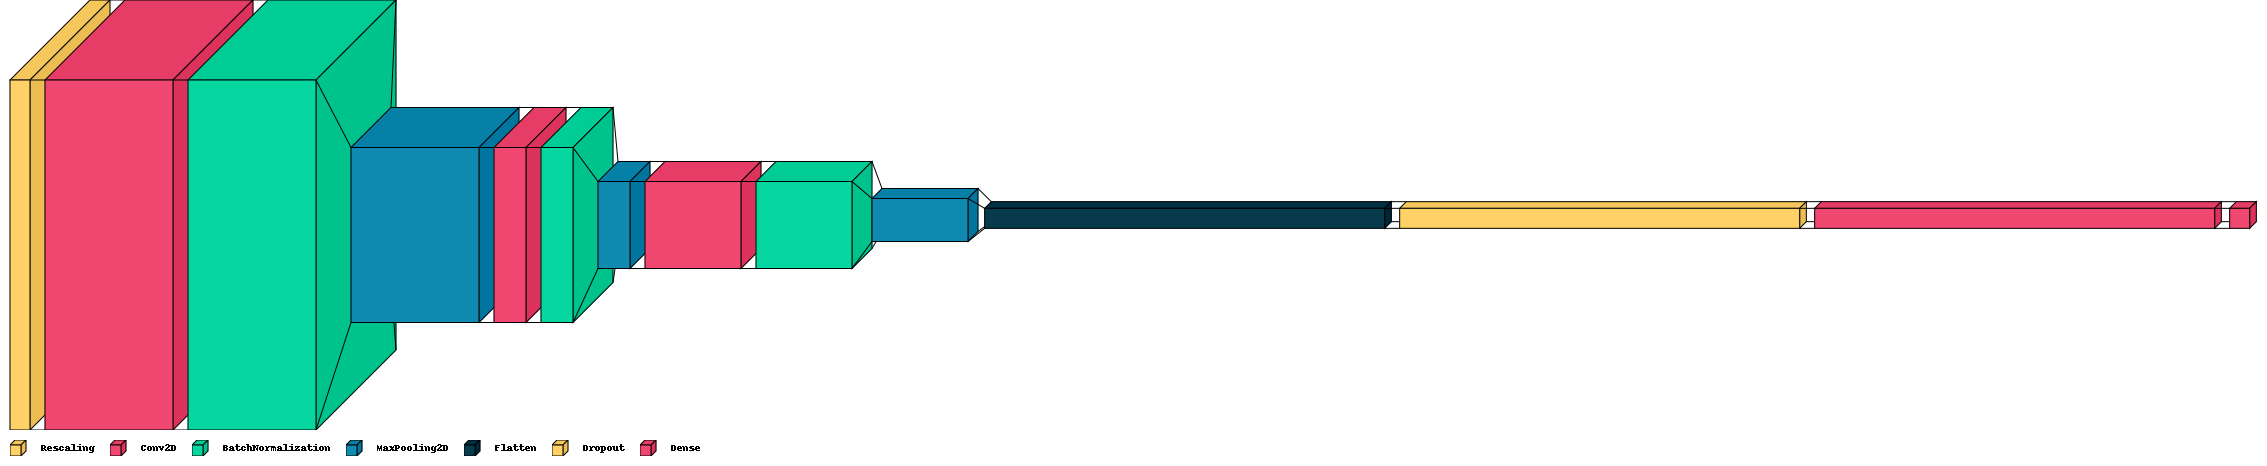

In [ ]:
visualkeras.layered_view(final_model, legend=True, spacing=15, scale_xy=1, scale_z=1, to_file='drive/MyDrive/DSA4266/final_model_viz.png') 

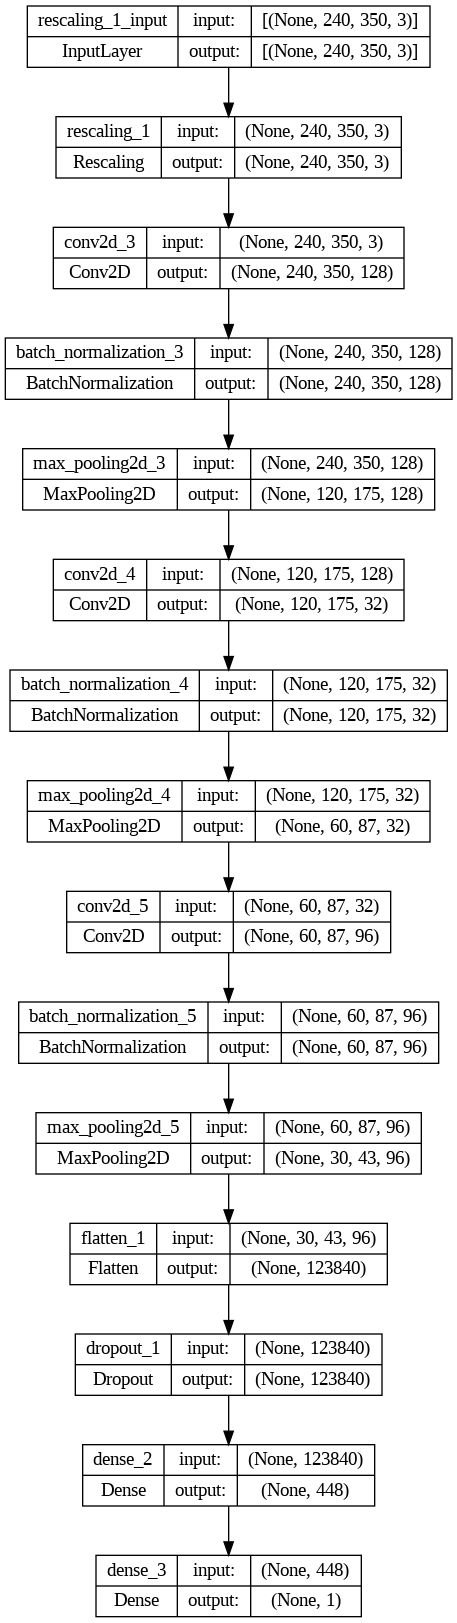

In [ ]:
plot_model(final_model,  show_shapes=True, to_file='drive/MyDrive/DSA4266/final_model_plot.png')

Since this model is same as the one trained in our hyperparameter tuning stage (With batch normalization), we can simple reload the model into the environment.  

In [ ]:
final_model = keras.models.load_model('drive/MyDrive/DSA4266/hyper_model_norm')

We have evaluated the model throughout the notebook using accuracy, precision, F1, TPR, TNR, FPR, FNR. These measures can be referred to under the evaluation done on Hypermarater Tuned model "With Batch Normalization"

Now let us further evaluate them using validation loss and AUC. 

In [ ]:
final_model.evaluate(test_ds)      #performance is also great

50/50 [==============================] - 3s 66ms/step - loss: 0.0655 - accuracy: 0.9834


[0.06551091372966766, 0.983428955078125]

ROC can give us an insight of how our model performs overall. This can be a great measure to also compare our model with other model architectures. 

In [ ]:
test_labels = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
def ROC_curve(predictions): 
  pred_ravel = predictions.ravel()
  fpr, tpr, thresholds = roc_curve(test_labels, pred_ravel)
  auc_model = auc(fpr, tpr)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

The ROC curve nearly touches the corner with an AUC of almost close to 1. This shows our model indeed performs very well. 

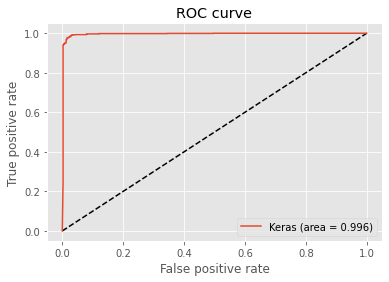

In [ ]:
ROC_curve(hyper_model_norm_predict)